In this project, we will be running over a dataset of diabetes admissions and treatment data, consisting of around 100,000 patient encounters.  

We are most interested in which types of factors or treatments most reduced readmission rates.  The paper from which this dataset was derived focused on using multivariate logistic regression of measurements of HbA1c against early readmission rates, but we will seek to find out if there are any other conclusions we can tease out from this dataset.  By doing so we will hope to find if there exist any features that show clear correlation with increased rates of readmission to the hospital and thus need to be tracked more closely by health care providers in the future.  

We will be training various classifiers (primarily Random Forest, though also Adaboost, GradientBoost, and Logistic Regression) to categorize our test data points into <30 days to readmission, >30 days to readmission, or no readmission.

Let's start by reading in our dataset.

The dataset can be found here:

Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

This dataset contains 10 years worth of clinical care data from 130 US-based hospitals regarding diabetic patients, containing information regarding stay length, medications, lab tests, and other data points.  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

data = pd.read_csv("diabetic_data.csv")

In [3]:
# Print out our data
print(data.columns)
print(data["readmitted"].value_counts())

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype:

Data:

There are just over 100,000 rows in our dataset, with 50 columns. 

I created a legend file that contains a full explanation and breakdown of the possible values in the github repository, but will briefly review the data types below.  

Let's take a quick look at each of our columns to get a feel for our input data types.

encounter_id, patient_nbr, and payer_code are internal identification metrics.

Race, Gender, and Age are categorical values in this dataset.   Ages are tiered into 10-year spans.  We will be dropping weight due to 97% of records missing values.  

admission_type_id, admission_source_id, or discharge_disposition_id represent as categorical values the types of place a patient came from or was discharged to. There is an ID mapping CSV in the github repository, should one wish to see what the exact values correspond to.

Num_/Number_ columns are integer values that correspond to the number of times a patient received a type of care, ie. num_procedures is the number of procedures performed on the patient during their hospital stay, while num_emergency corresponds to the number of ER visits in the year proceeding the encounter.  

max_glu_serum and A1Cresult correspond to categorical thresholds of lab result ranges.  The value thresholds in each correspond to very high, high, normal, and not measured.  

Diag_1,2, and 3 are saved as ICD-9 Codes of the diseases the patient was admitted to the hospital with.  Diag_1 is the primary diagnosis of the visit, whereas diag_2 and 3 are secondary diagnoses. We will revisit this later down the line, but for now we will treat each as its own categorical variable.  

The medication column names (ie. metformin, repaglinide, etc.) are whether or not a patient was taking the given diabetic medication during their hospital stay, and if so at an increased, steady, or decreased dosage compared to their home rate.  

change corresponds to whether or not a patient had their meds changed during their hospital stay. 

DiabetesMed corresponds to whether or not a diabetes medication was prescribed.  

Finally, and as mentioned above, our readmission rates are divided into <30 days to readmission, >30 days to readmission, and no readmission. 

Also, lets look at the distribution of our readmission rates data.  We are at roughly 55,000 Nos, 35,000 >30 days, and 11,000 <30 days.  


Data Cleaning: 

As mentioned above, the values in Encounter ID, Patient Number, and Payer Code are not useful data points for us, as they correspond to internal hospital coding system numbers with no consistent data points.  As such, we will remove them. 

Unfortunately, this data set is mostly missing weight and medical specialty data, so we must remove those columns as well.  There are actually almost no missing data points across all other columns. 

Patient Discharge Dispositions 10, 19, 20, 21 correspond to the patient unfortunately passing away during their initial hospital visit, so they should not be factored into readmission calculations.  We will make sure to remove any rows where the patient died and thus would never have any chance to be readmitted.  

In [23]:
print(data.shape)

# Remove non-useful columns
processed_data = data.drop(columns = ["weight", "patient_nbr", "encounter_id", "payer_code", 'medical_specialty', ])

# Remove rows that we cannot use readmission data for
discharge_ids = [10, 19, 20, 21]
processed_data = processed_data[~processed_data['discharge_disposition_id'].isin(discharge_ids)]

print(processed_data.shape)

(101766, 50)
(101750, 45)


We can see we've removed 5 columns and 16 rows from our data.  

With the data cleaned, we can begin exploratory data analysis.  

First let's examine the categorical columns as they relate to readmission rates.  These include values like ethnicity, gender, admission source, whether they are on diabetes meds, and diagnosis type.  

We will be looking at the rough proportion of readmission values, and also tabulate the total counts.  We will only be tabulating the top 8 values across all data points; this is particularly necessary at the diag_ columns, where there are 9000+ unique values.

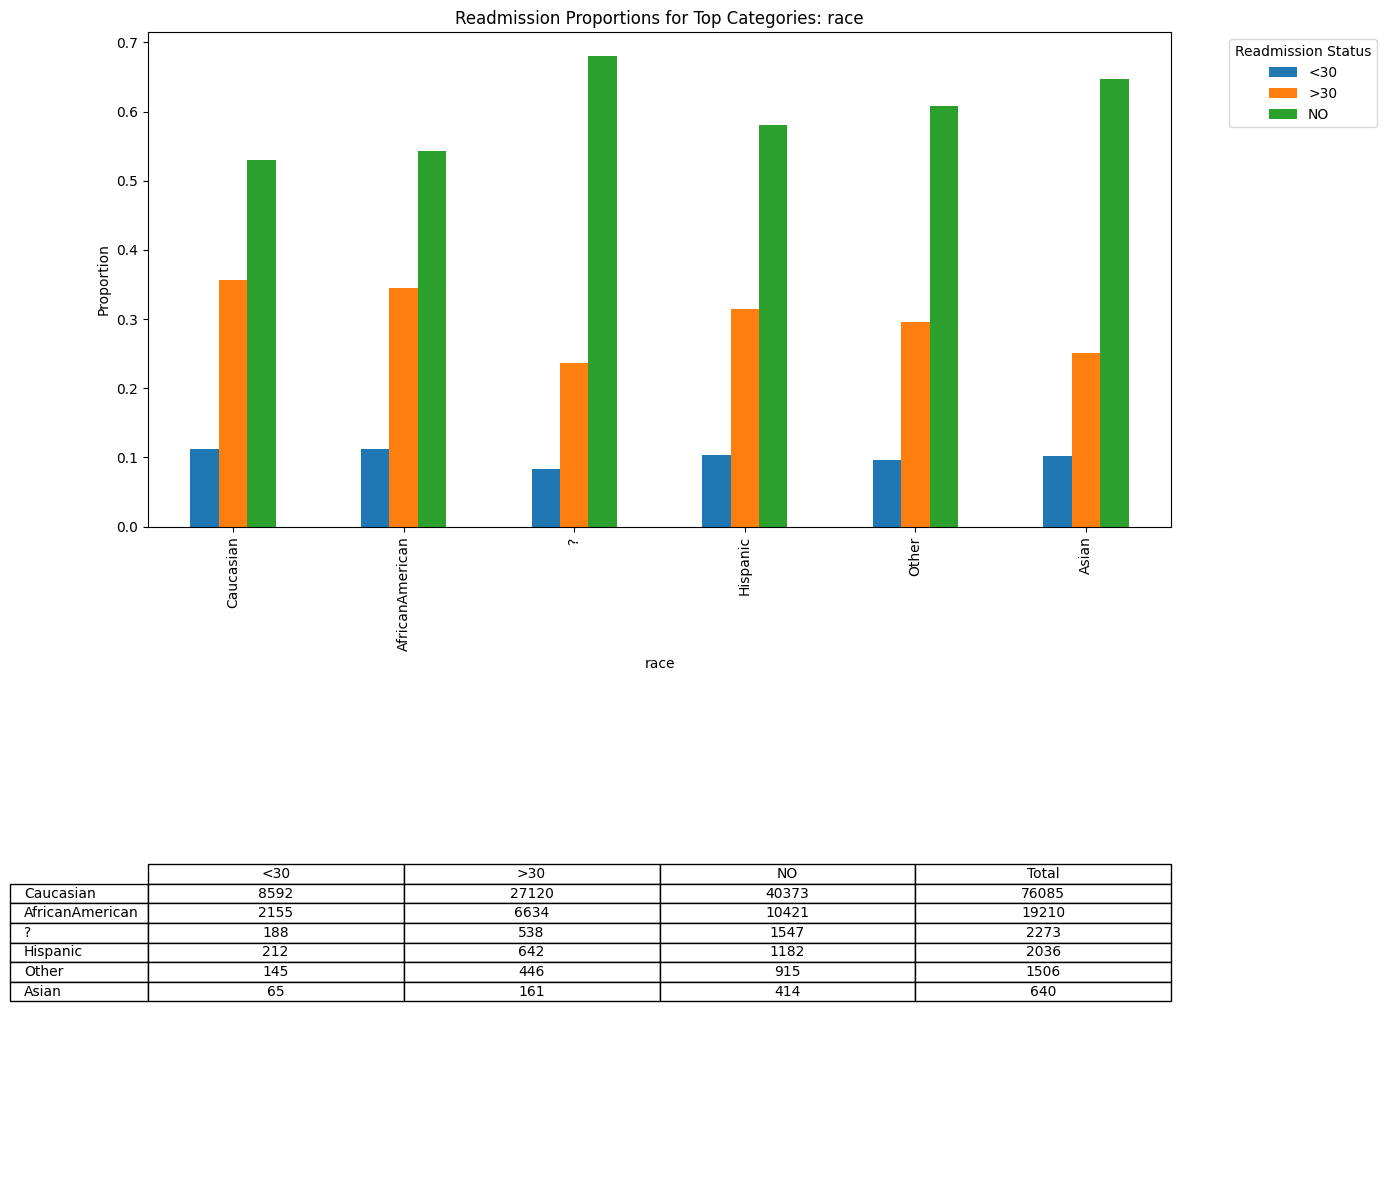

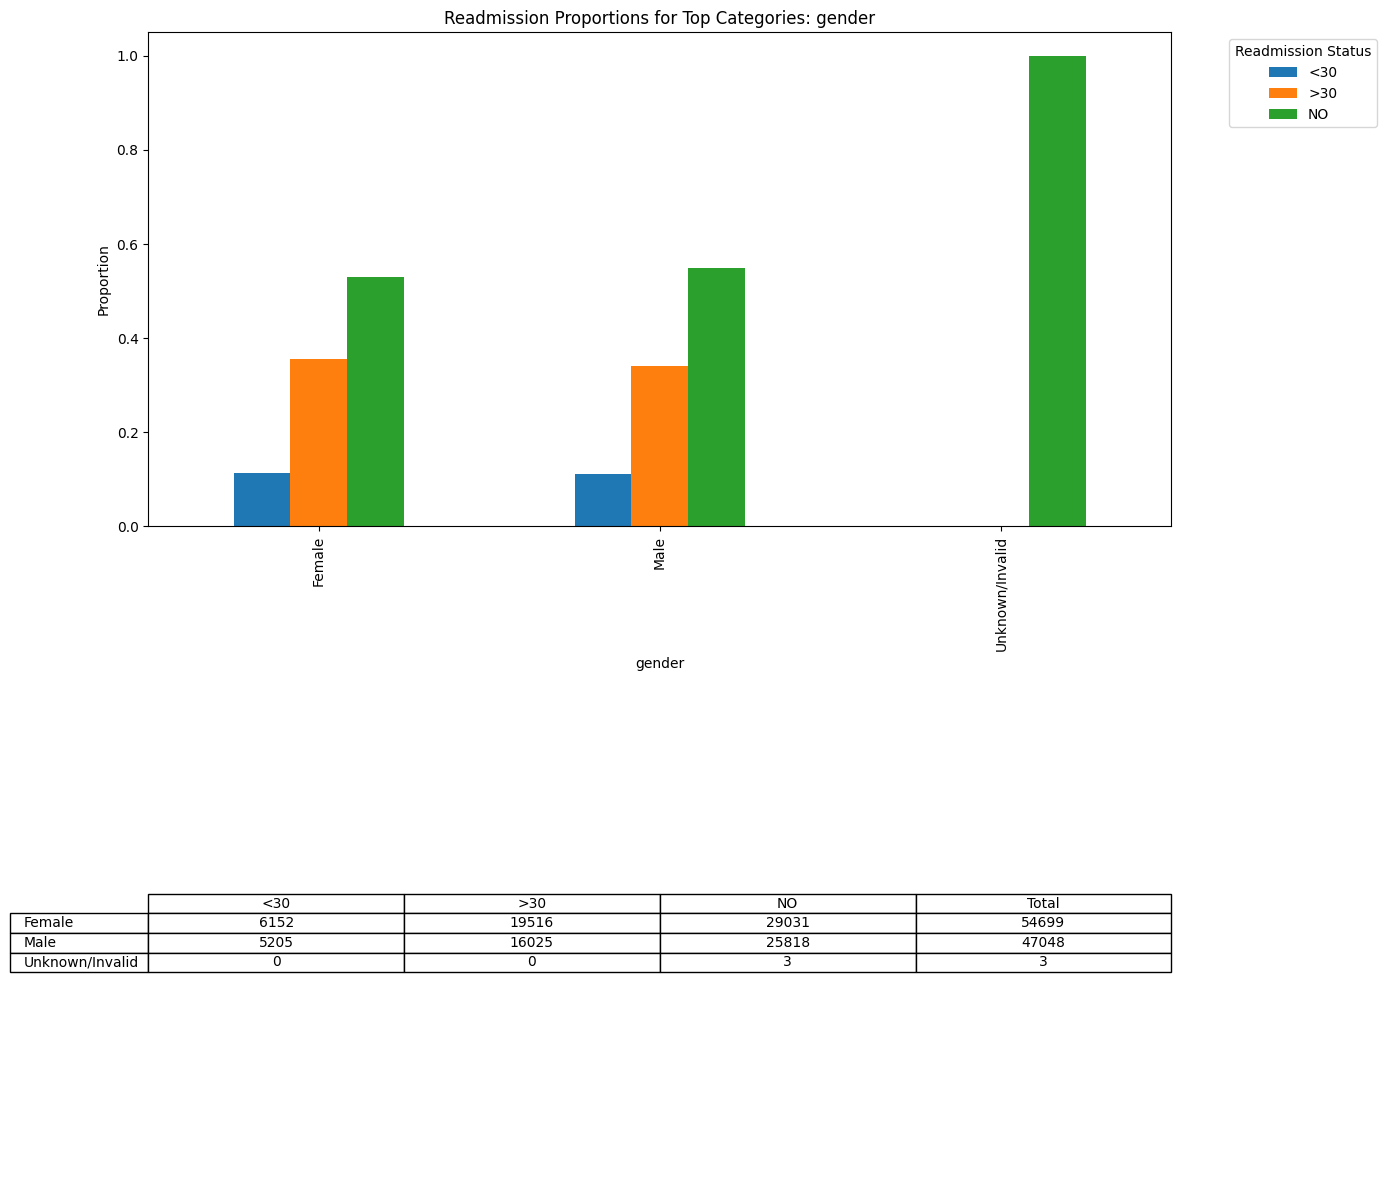

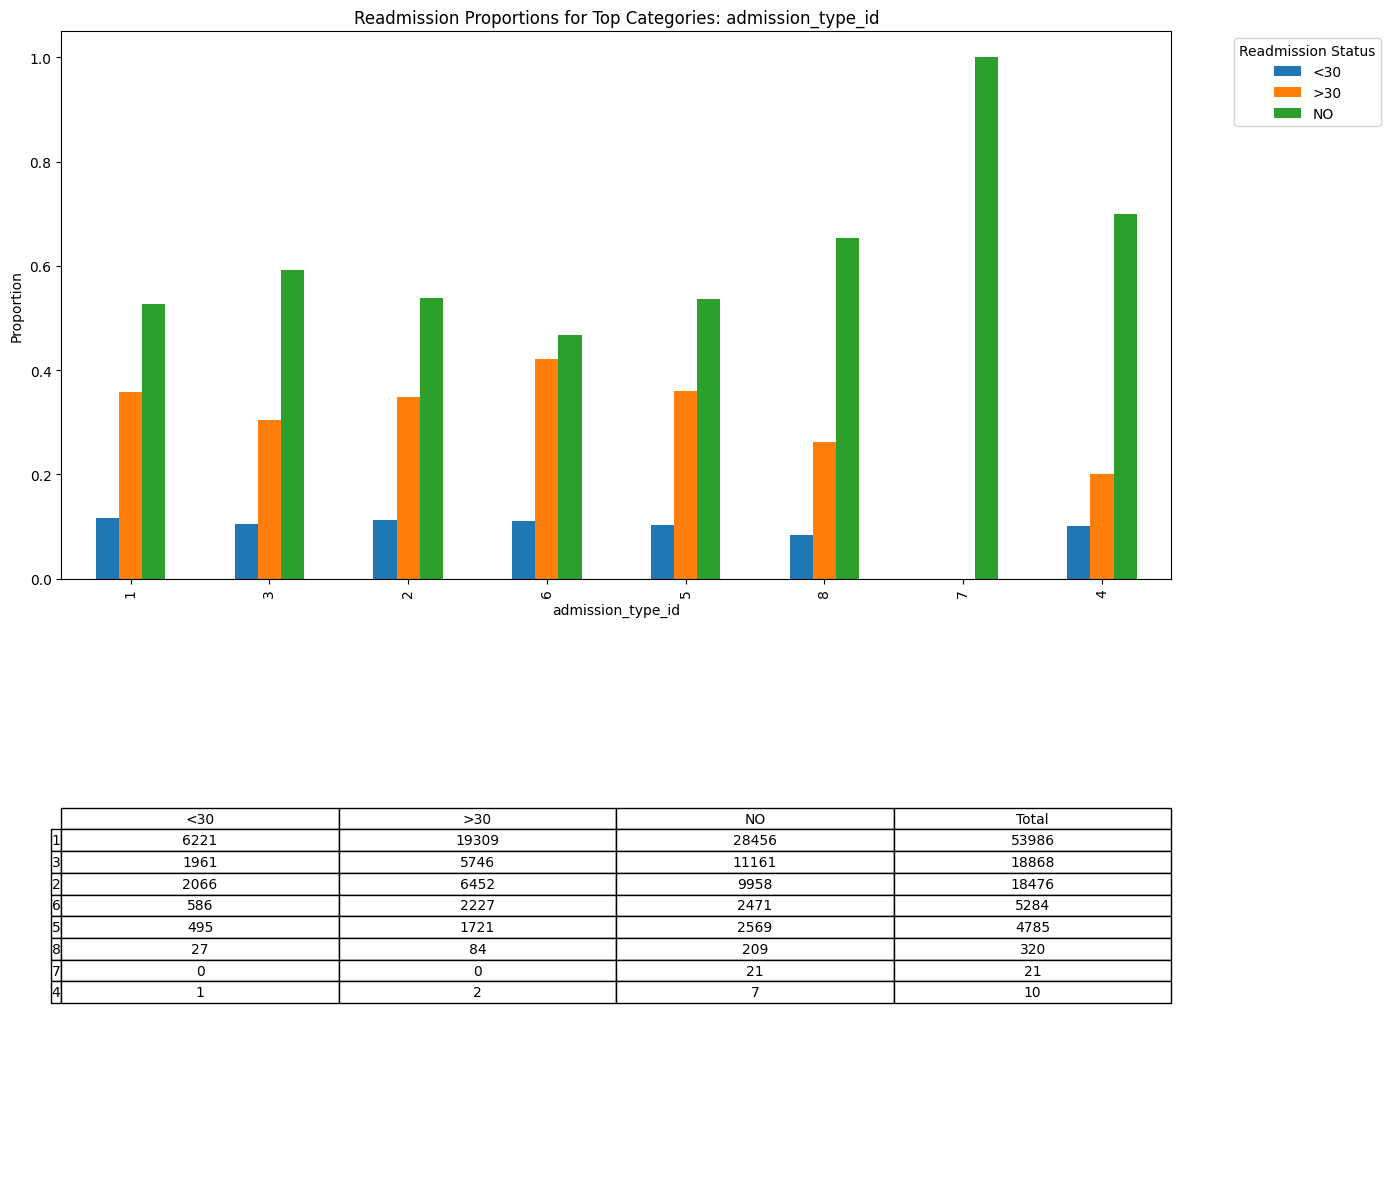

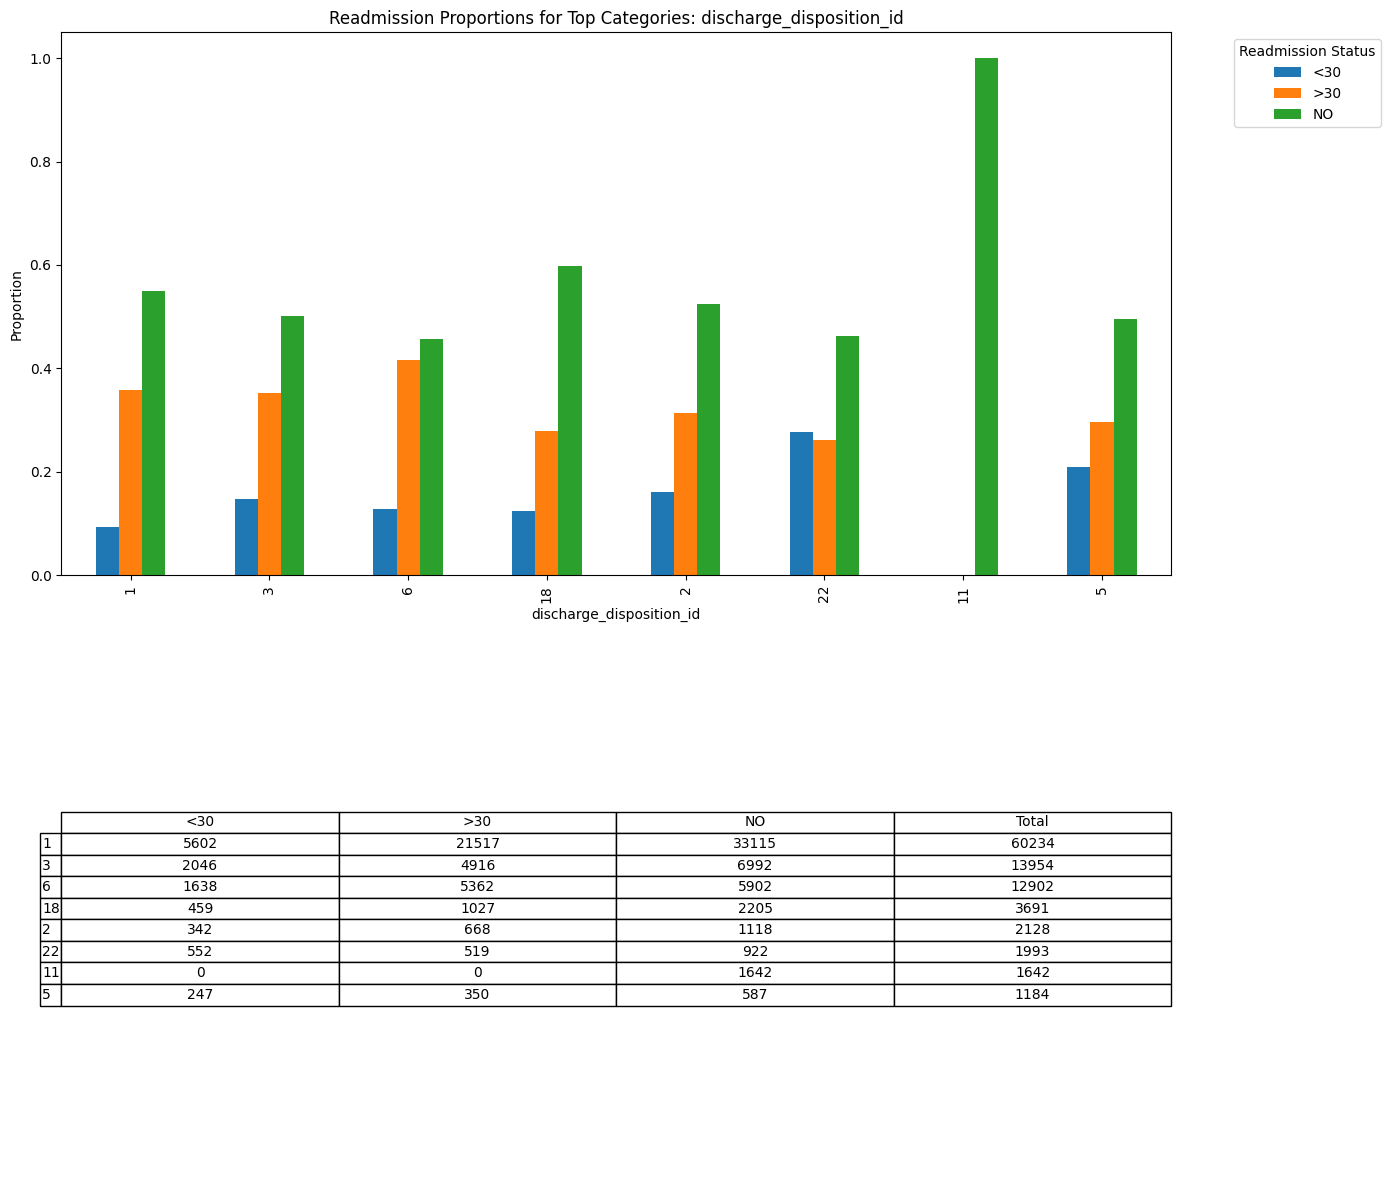

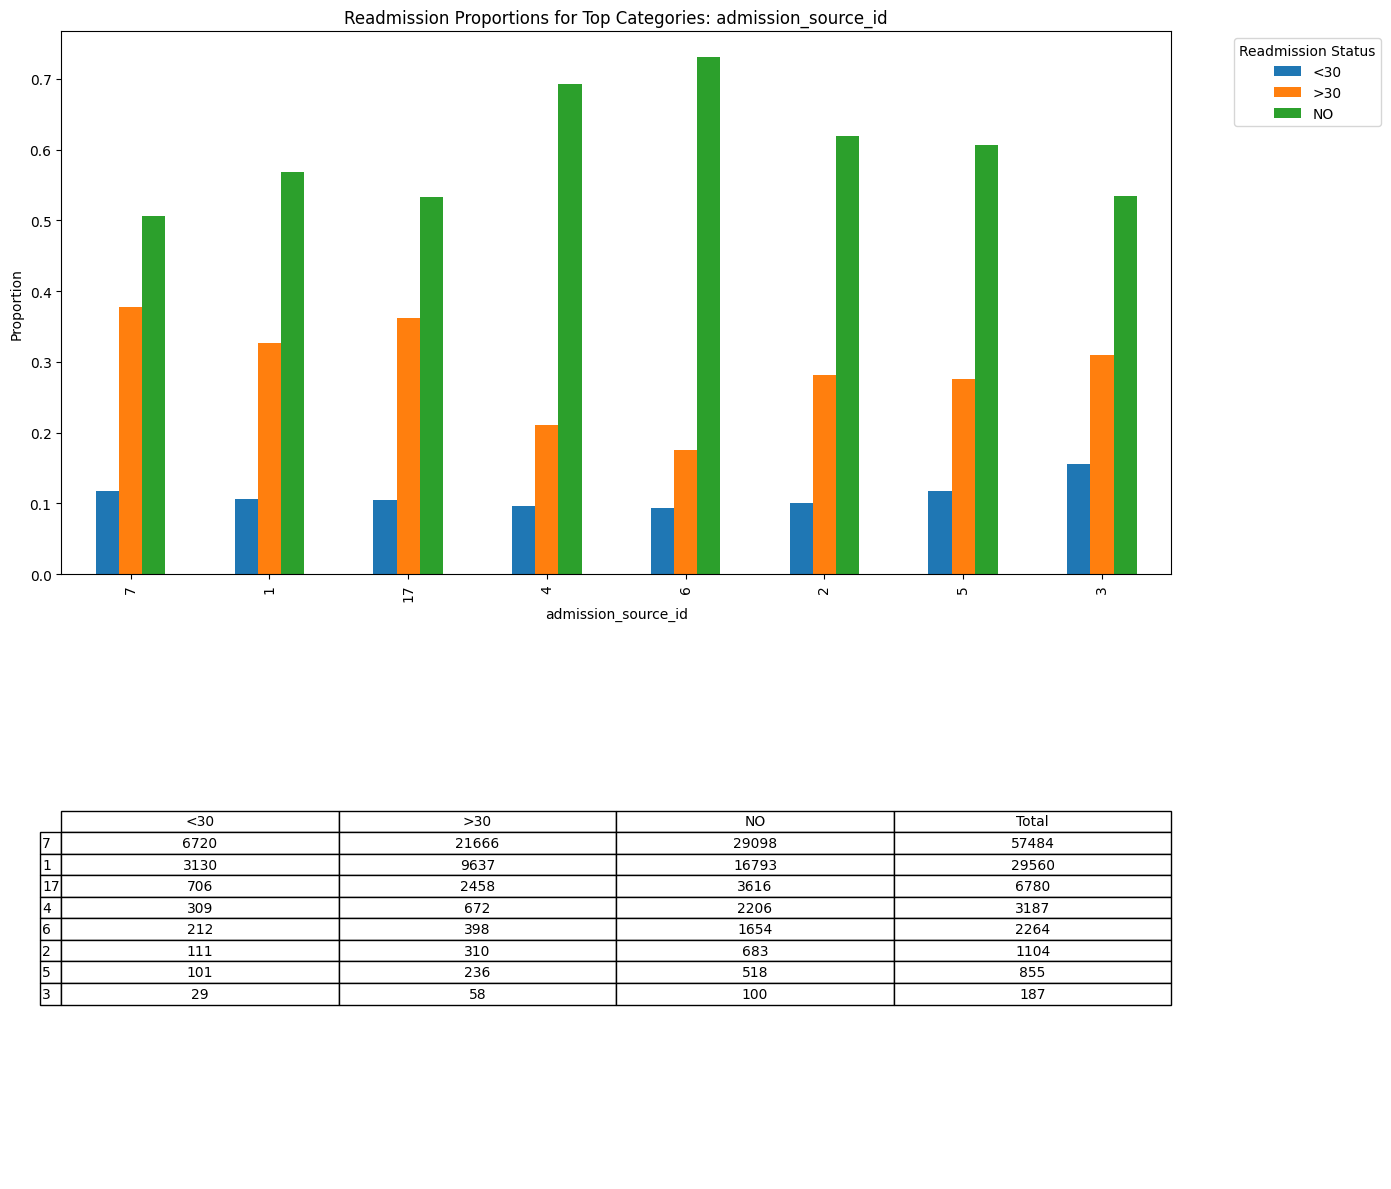

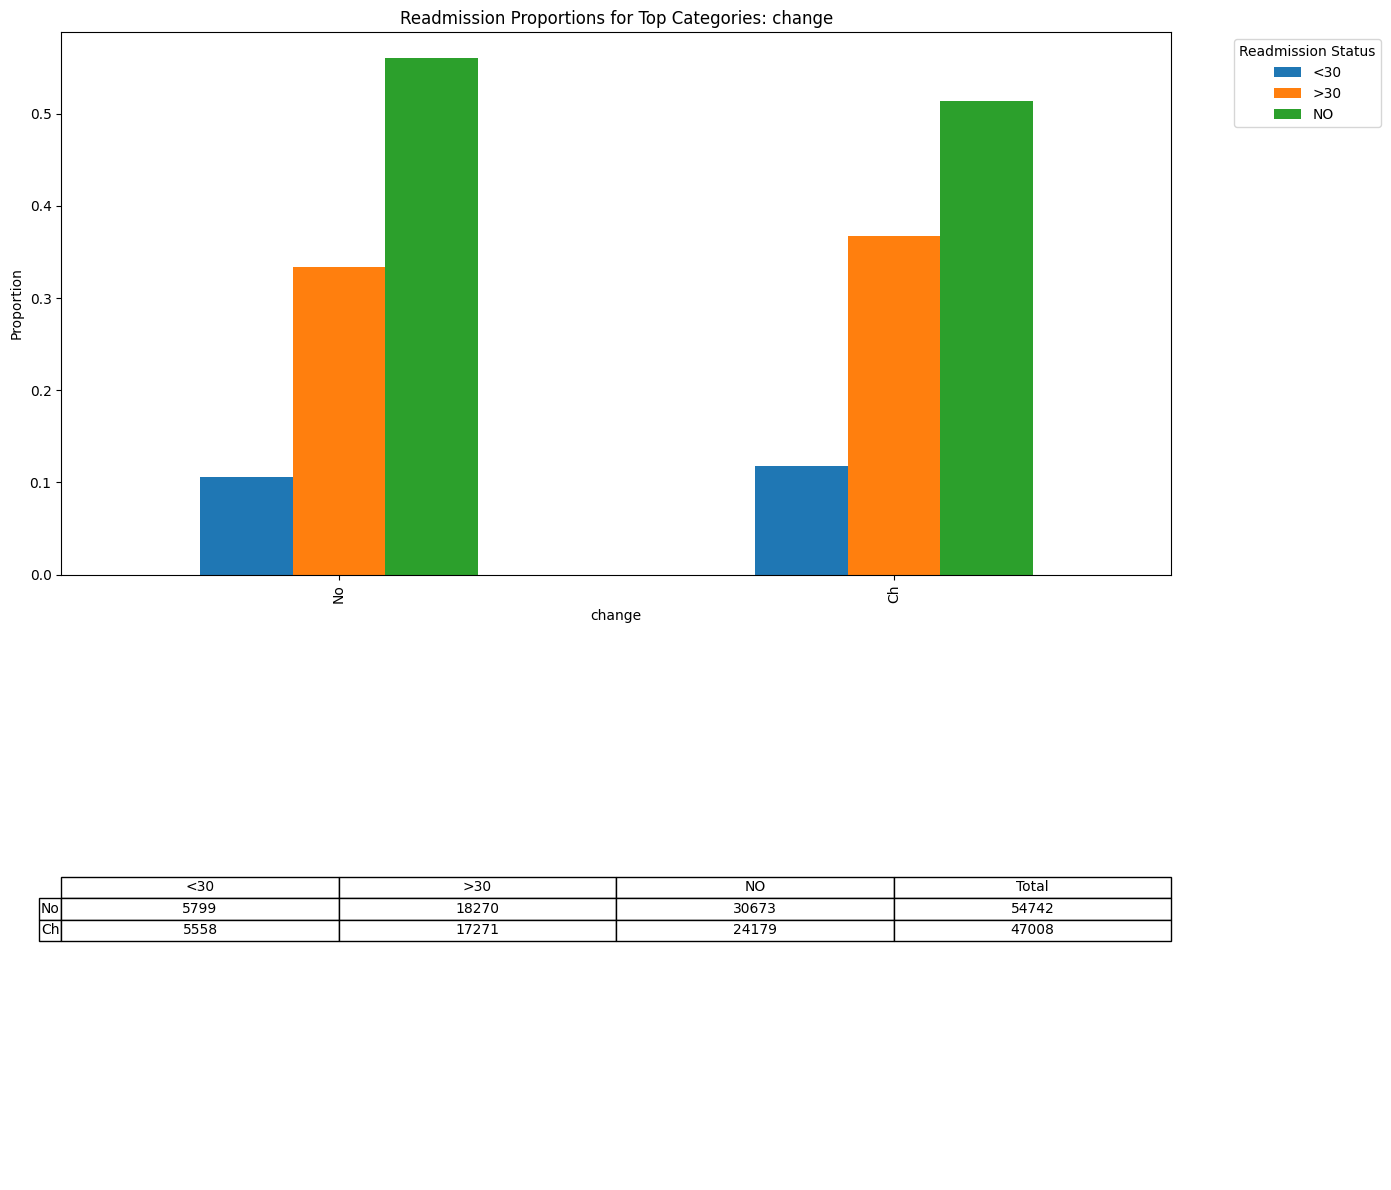

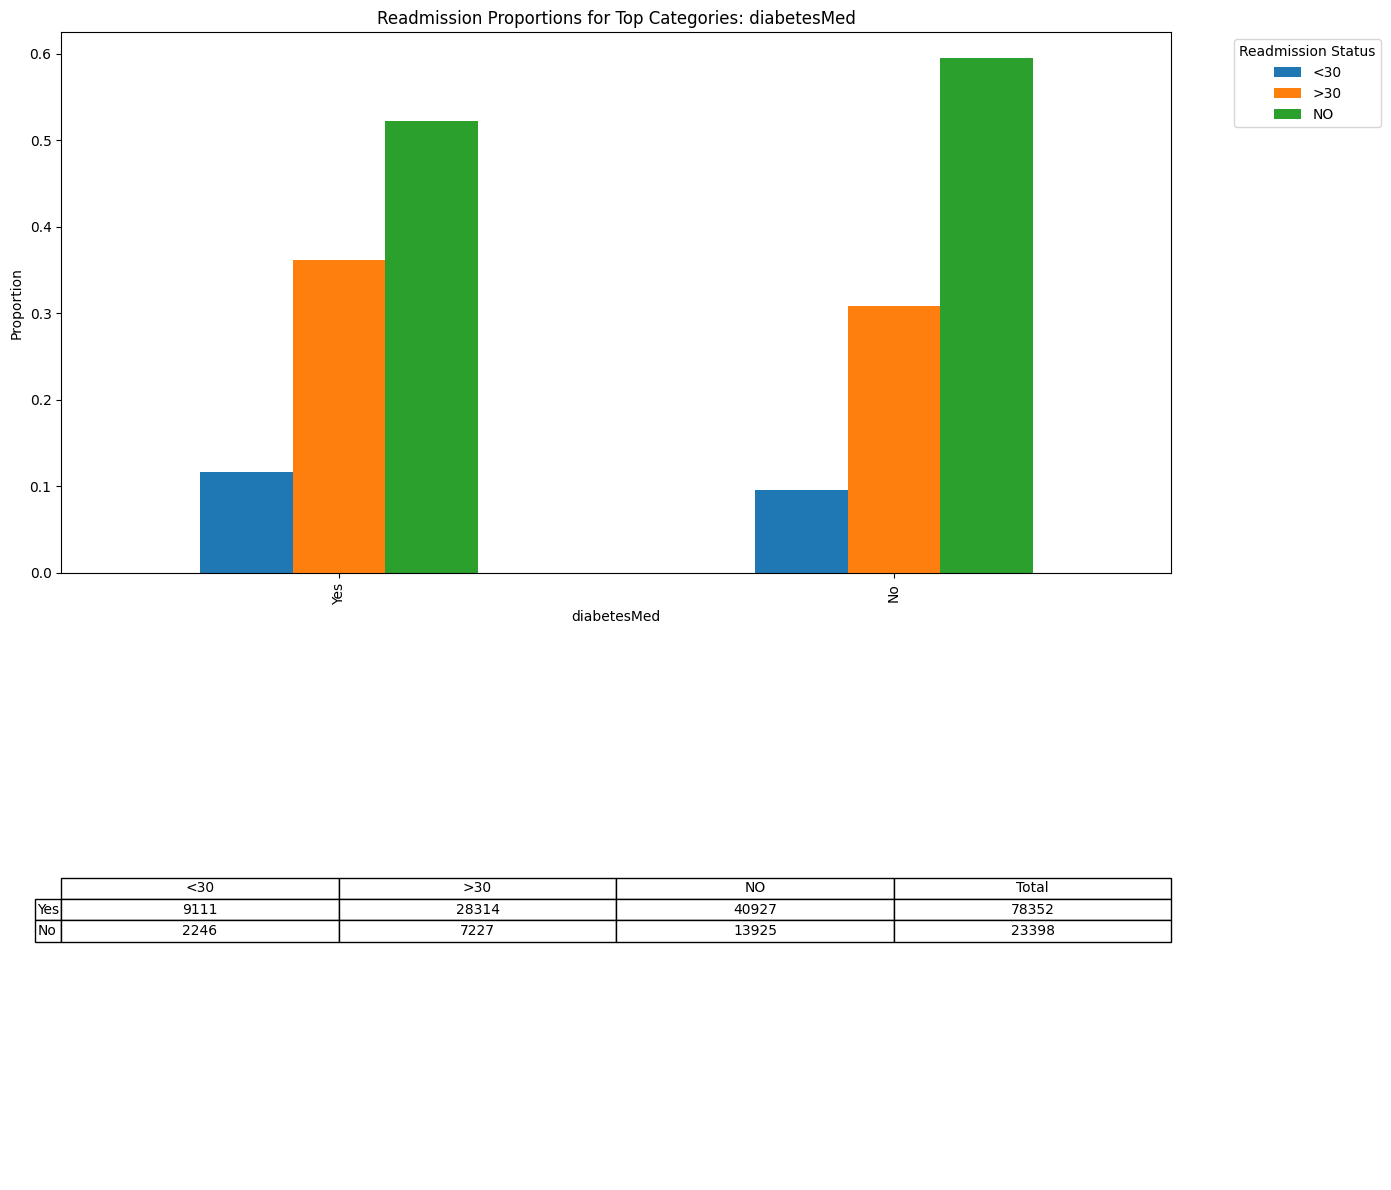

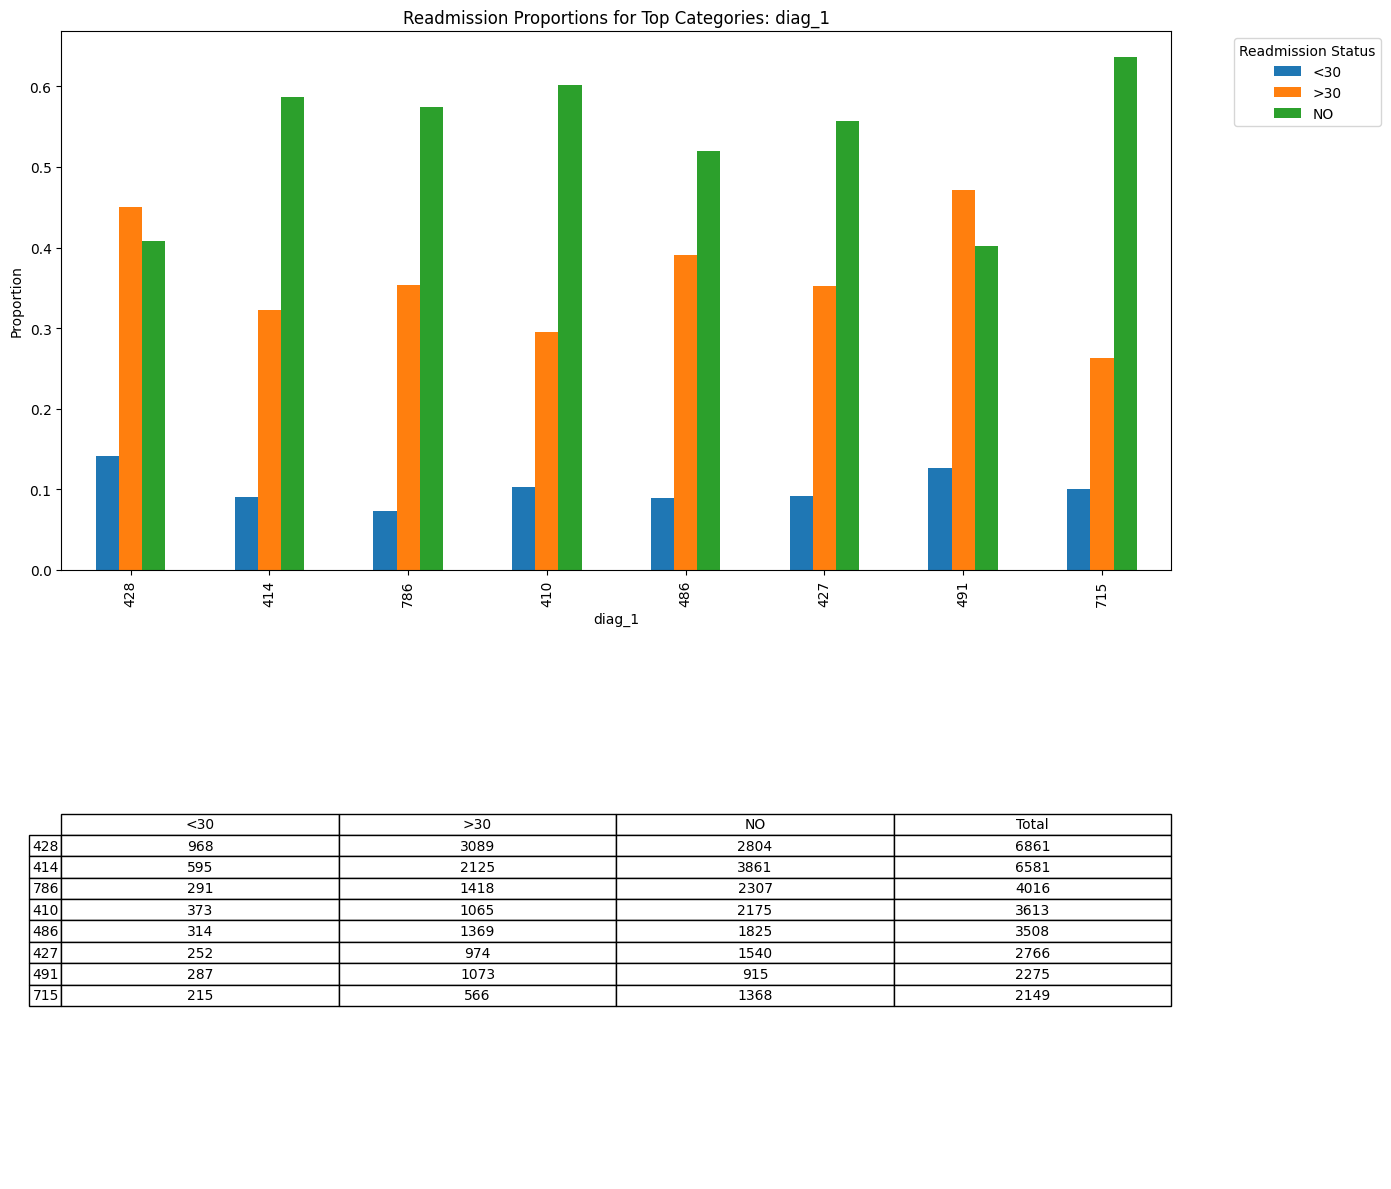

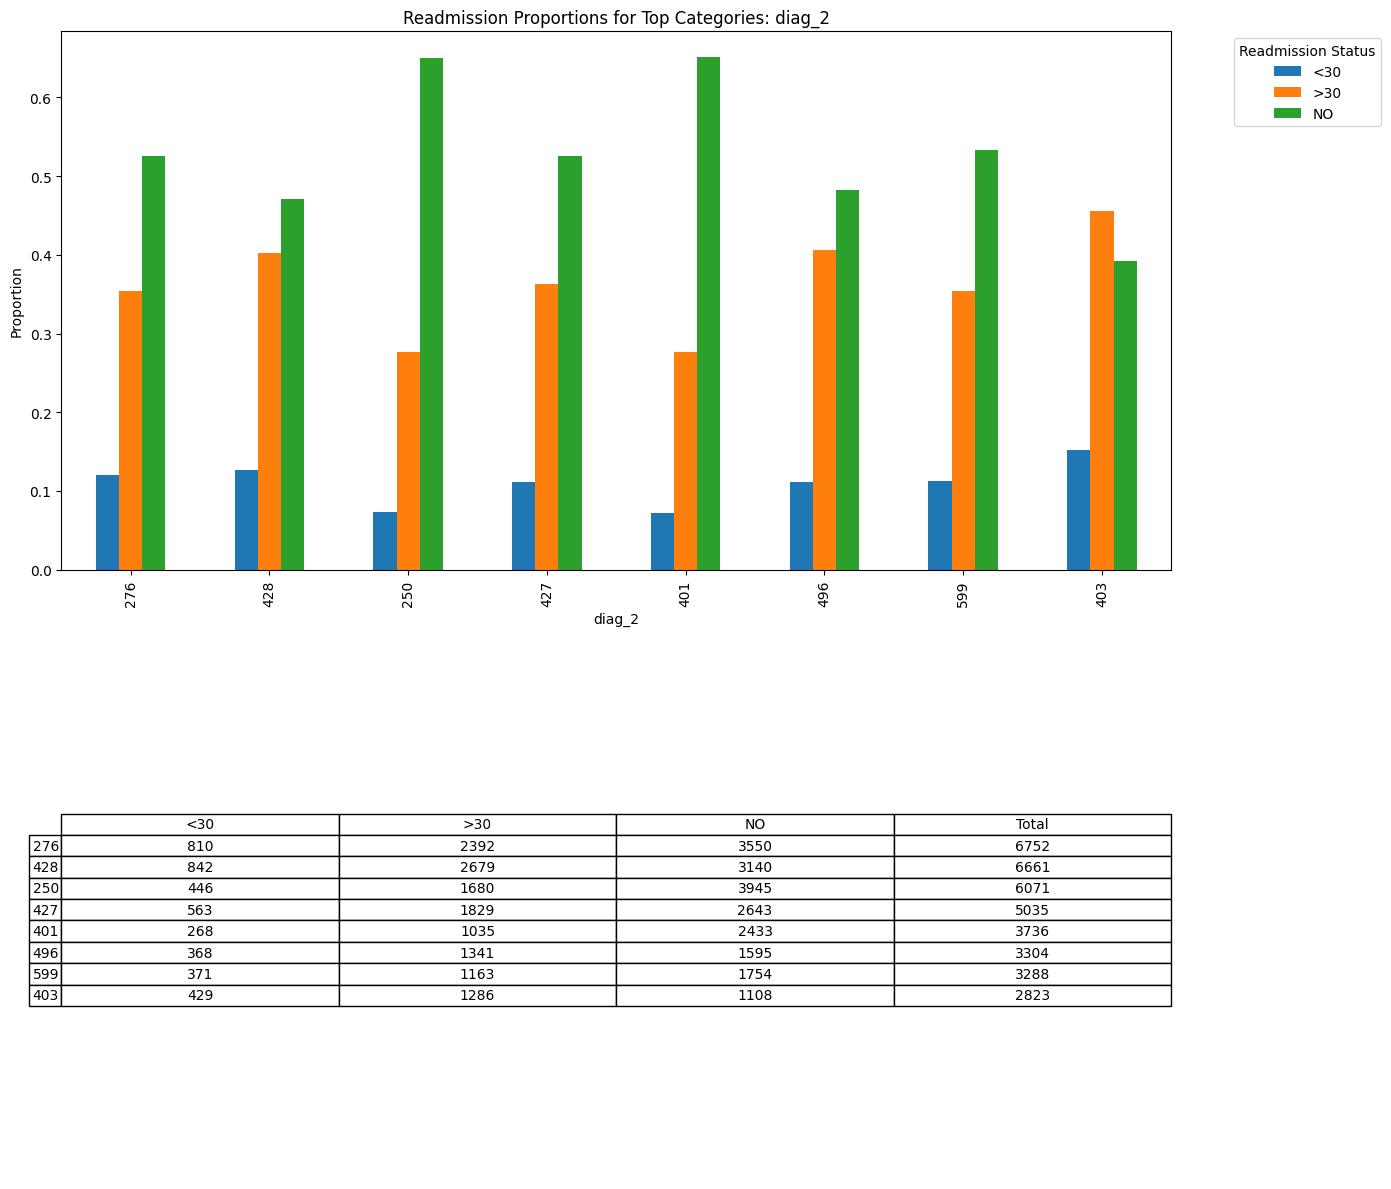

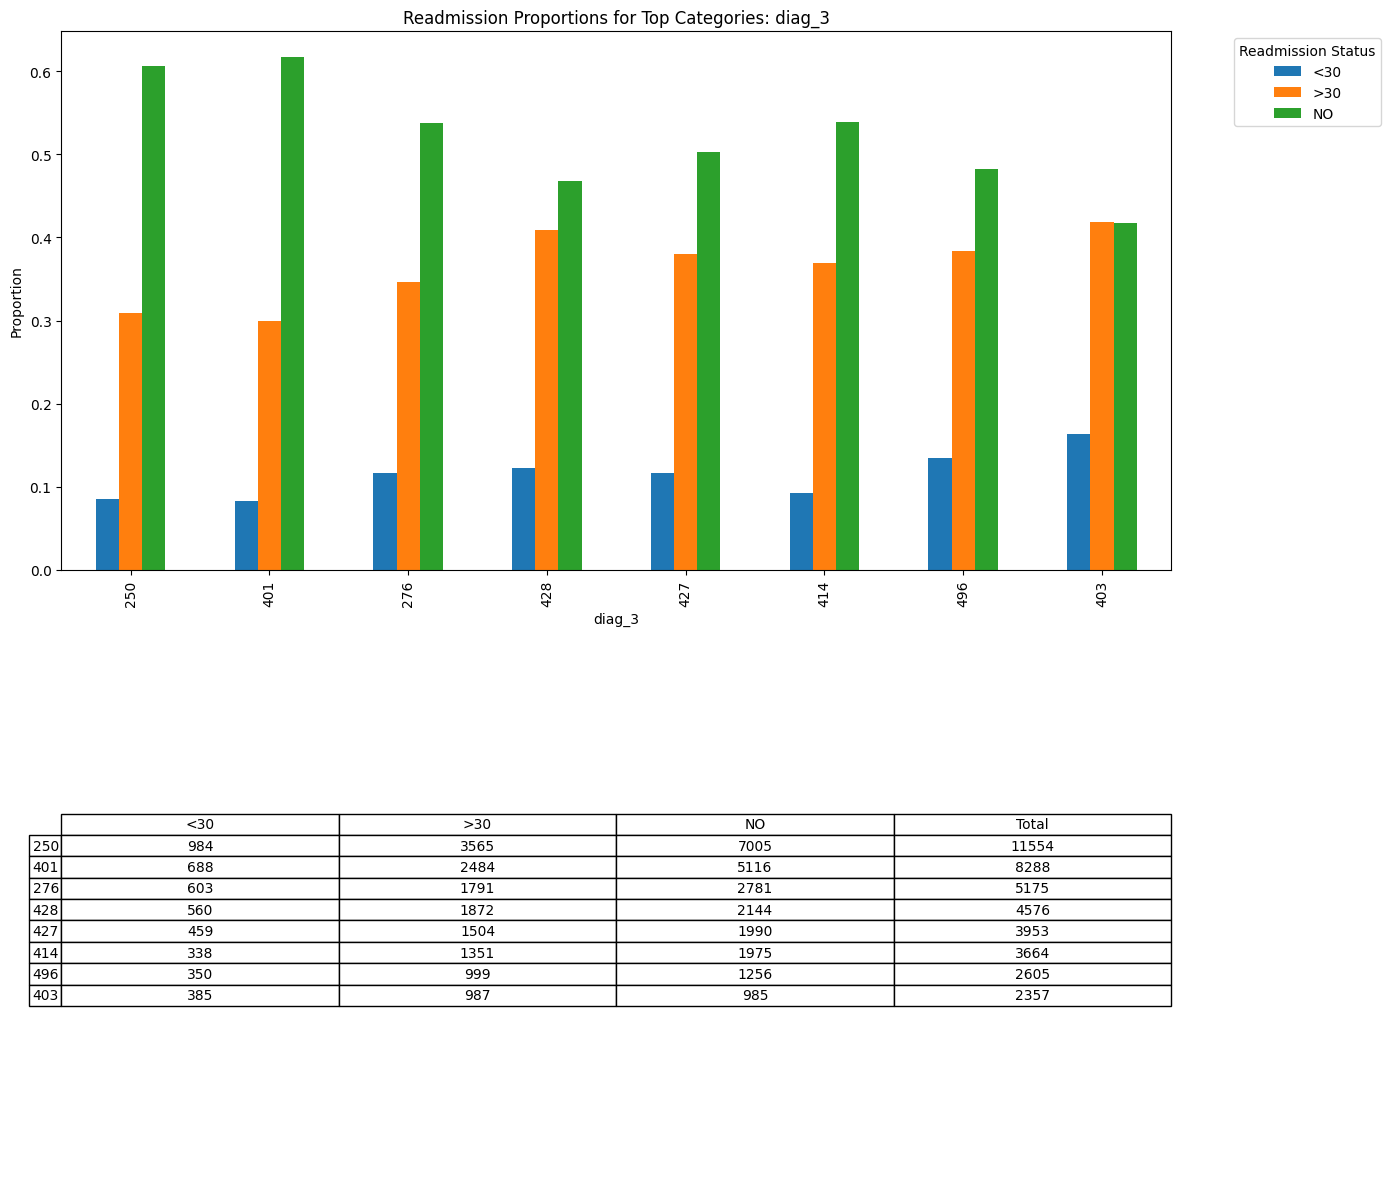

In [5]:
# Columns with categorical values
categorical_cols = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                    'admission_source_id', 'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3']

# Loop through each column
for col in categorical_cols:
    
    # Calculate the counts and the proportions of the values within the given column
    readmission_counts = processed_data.groupby(col)['readmitted'].value_counts().unstack().fillna(0)
    readmission_props = processed_data.groupby(col)['readmitted'].value_counts(normalize=True).unstack().fillna(0)
    
    # Sort by total
    readmission_counts['Total'] = readmission_counts.sum(axis=1)
    readmission_counts = readmission_counts.sort_values('Total', ascending=False)
    readmission_props = readmission_props.loc[readmission_counts.index]
    
    # Select the top values; chose 8 here as it showed most data relative to size of graph
    selected = readmission_counts.head(8).index
    
    # Create a figure with two subplots, one for the bar graph and one for the table 
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # Plot proportions on bar graph
    readmission_props.loc[selected].plot(kind='bar', stacked=False, ax=ax1)
    ax1.set_title(f'Readmission Proportions for Top Categories: {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Proportion')
    ax1.legend(title='Readmission Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Table counts 
    ax2.axis('off') 
    table = ax2.table(cellText=readmission_counts.loc[selected].values.astype(int), 
                    colLabels=readmission_counts.loc[selected].columns, 
                    rowLabels=readmission_counts.loc[selected].index,
                    loc='center', 
                    cellLoc='center')
    
    plt.tight_layout()
    plt.show()

It looks like there aren't any particularly outstanding features in our data that we can pinpoint as being hugely impactful on first glance. Let's move on to our numerical columns.

Here, we will handle our numerical categories; values like the number of diagnoses made while staying in the hospital, total hospital stay, or the number of outpatient visits the patient has made over the year.  

We'll take a look at these, visualized as a box plot to show the rough distribution of the variables.  

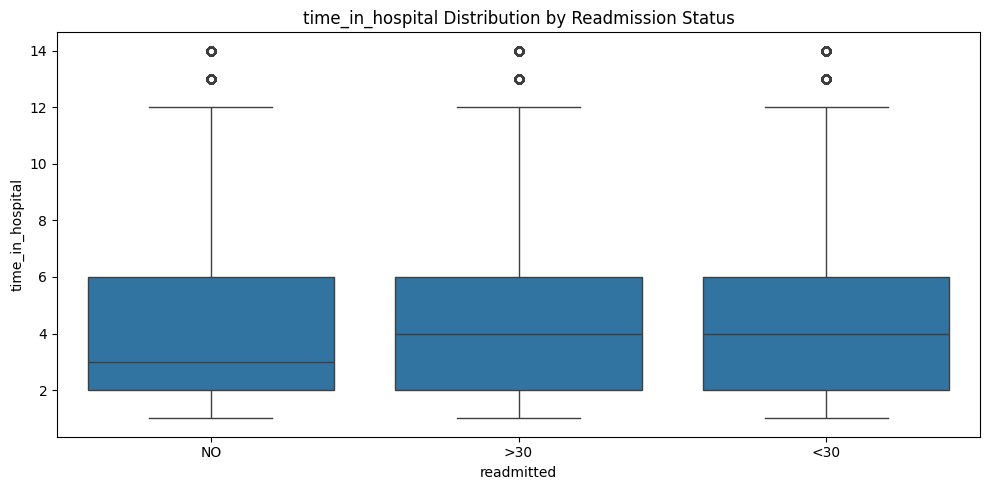

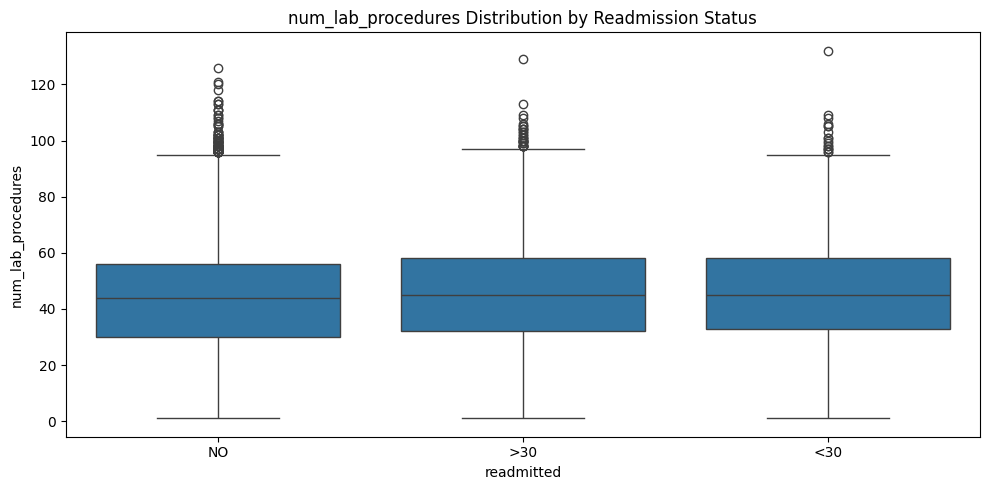

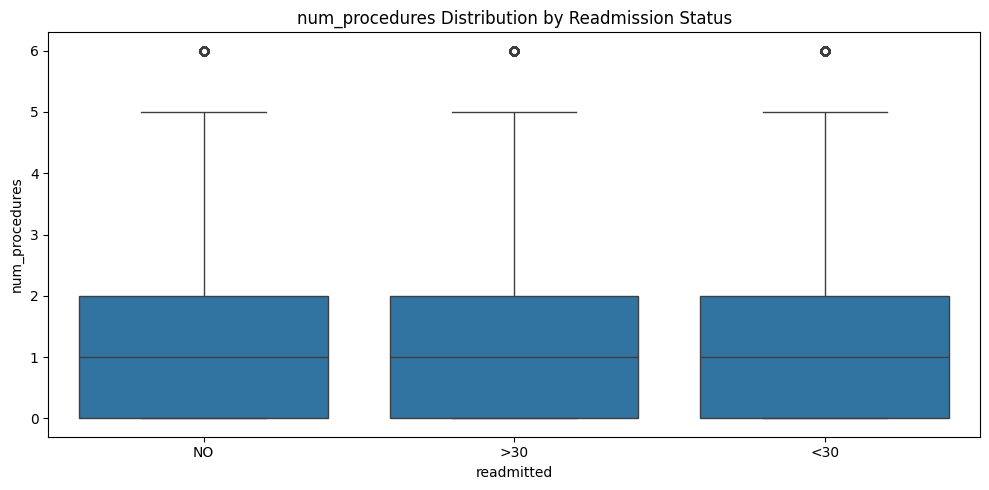

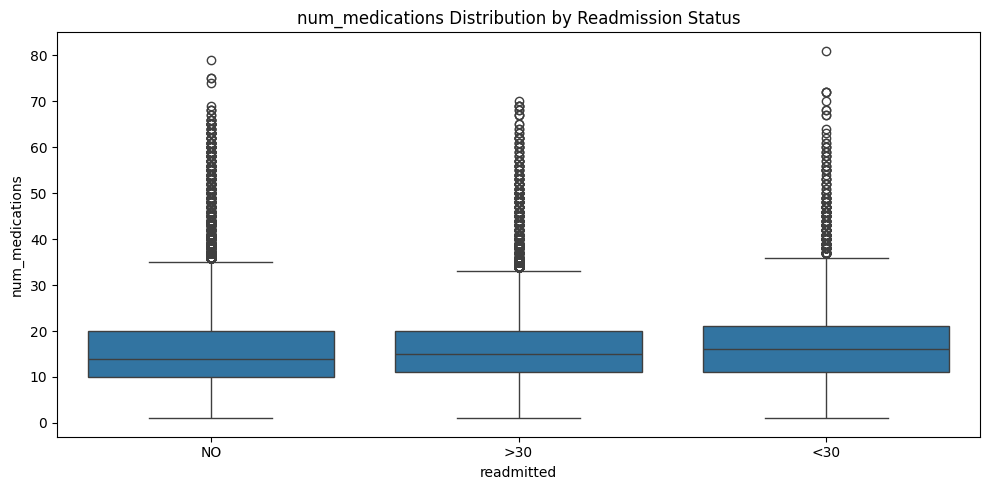

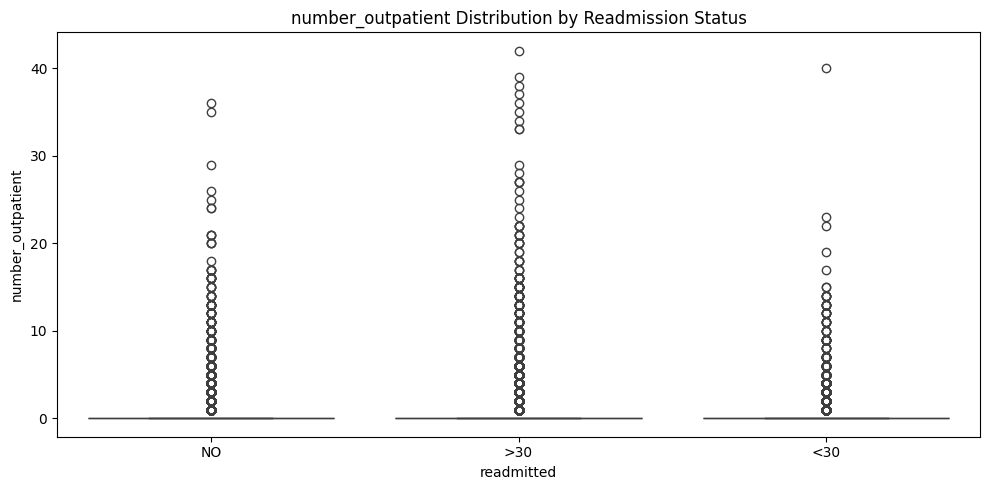

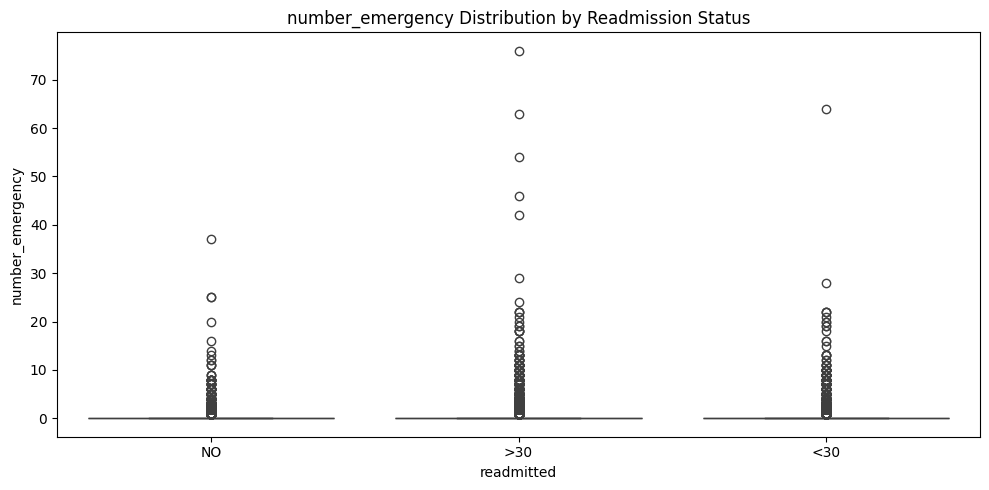

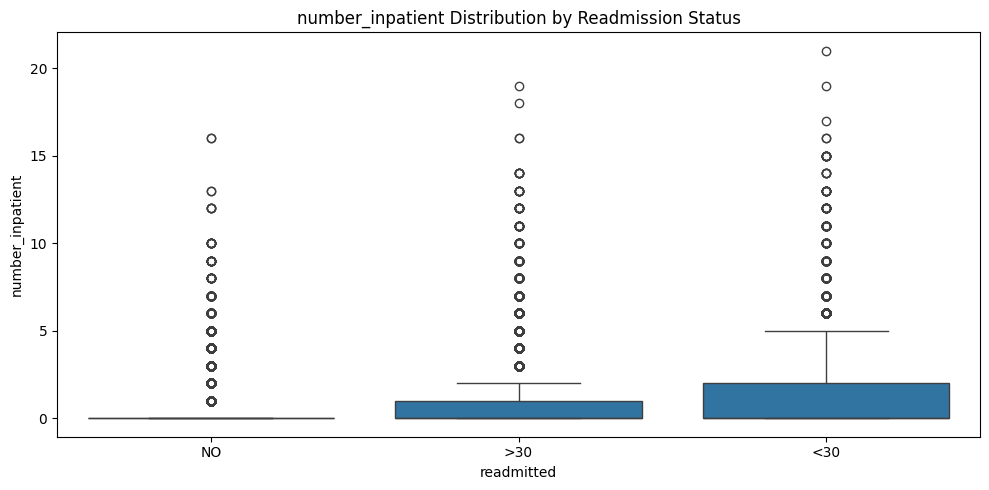

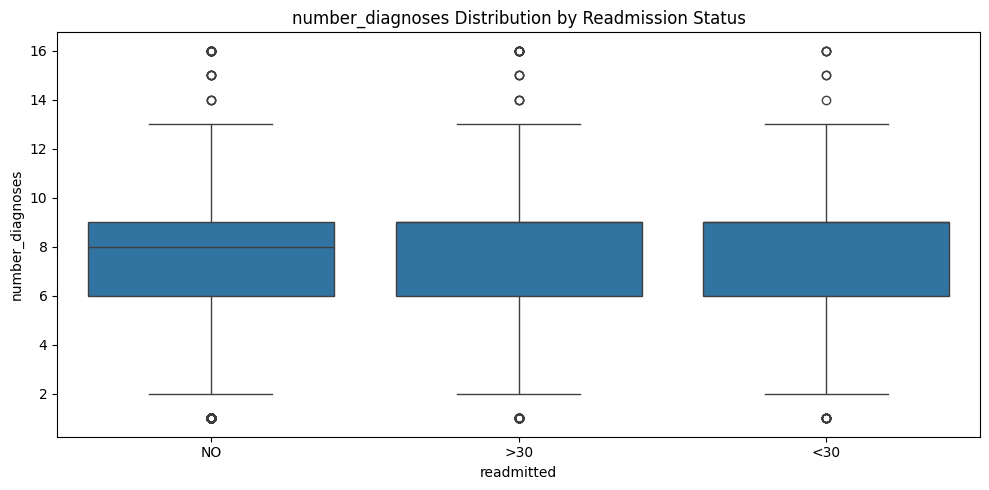

In [7]:
# Numerical variables
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 
                  'num_procedures', 'num_medications', 'number_outpatient', 
                  'number_emergency', 'number_inpatient', 'number_diagnoses']

# Loop through numerical columns
for col in numerical_cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='readmitted', y=col, data=processed_data)
    plt.title(f'{col} Distribution by Readmission Status')
    plt.tight_layout()
    plt.show()

There may be some more data to tease out here than the categorical columns, but unfortunately it seems once again there is nothing conclusively demonstrative. 

Lastly, let's look athrough the specific medications patients have been taking. 

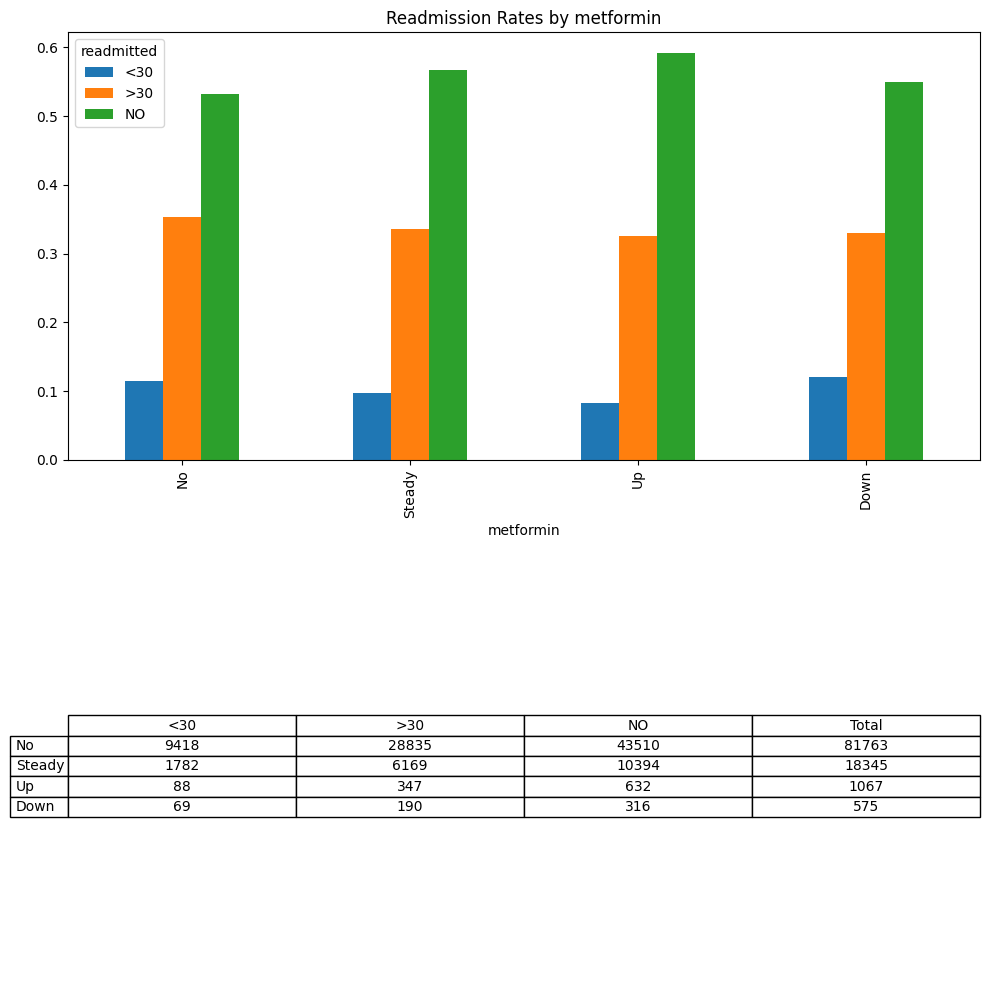

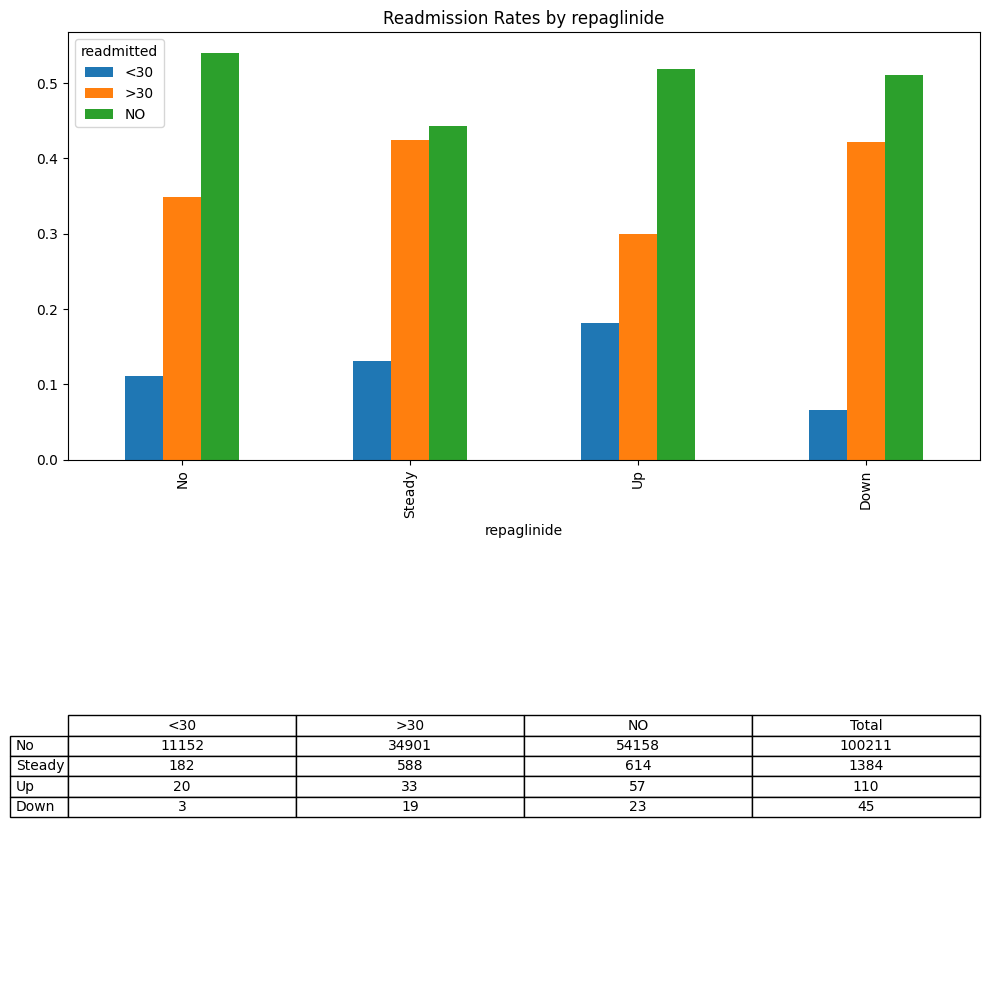

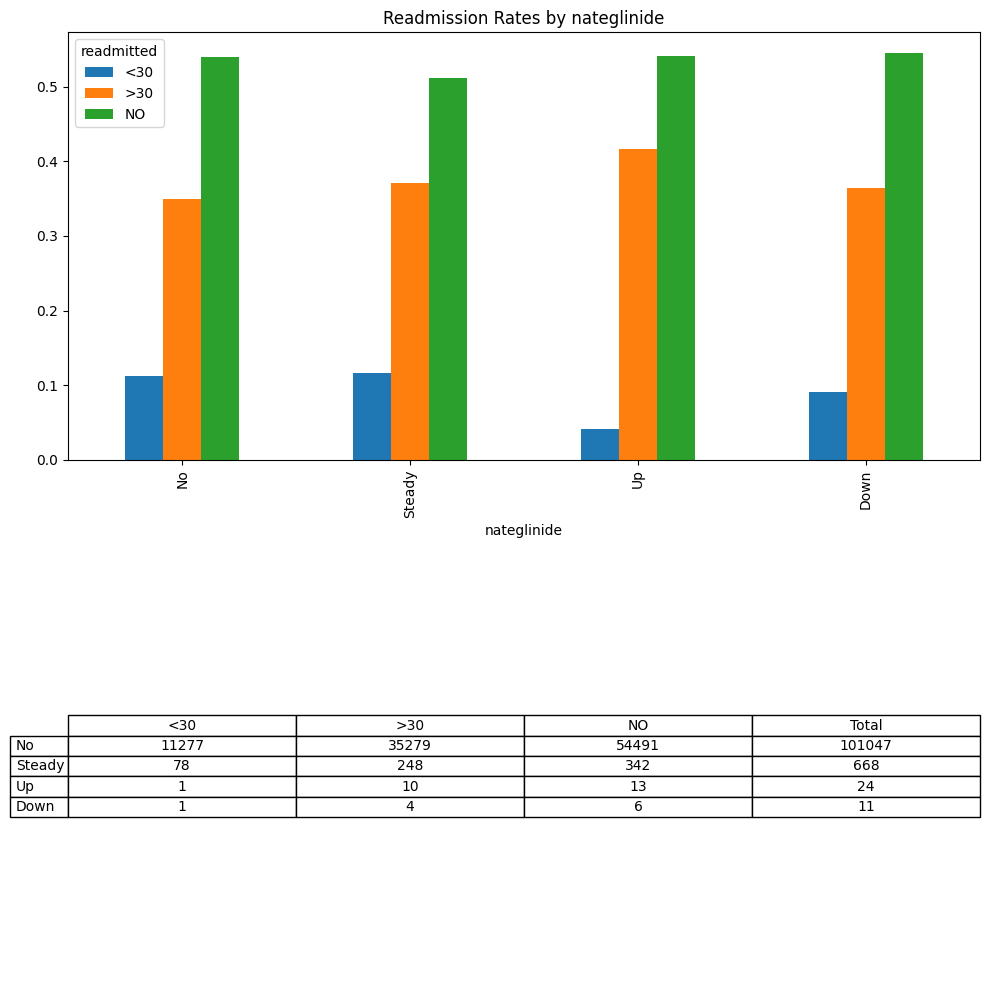

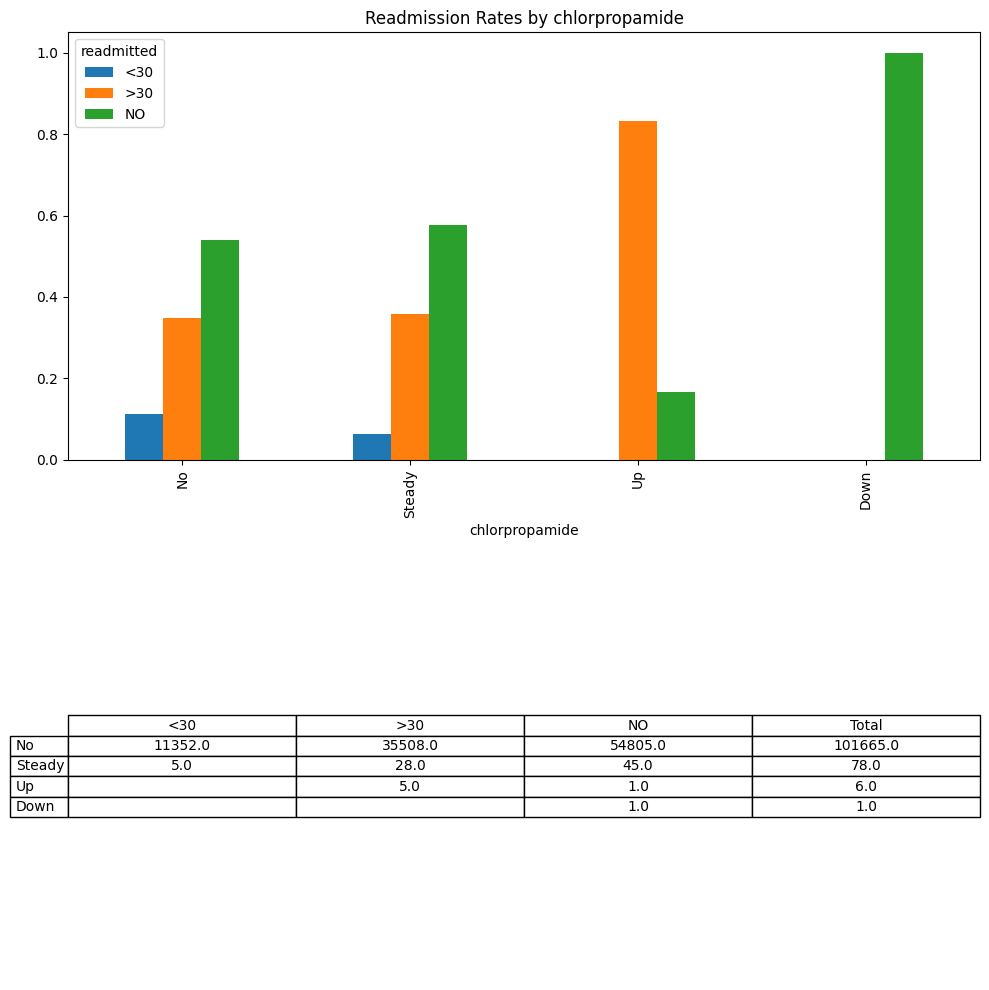

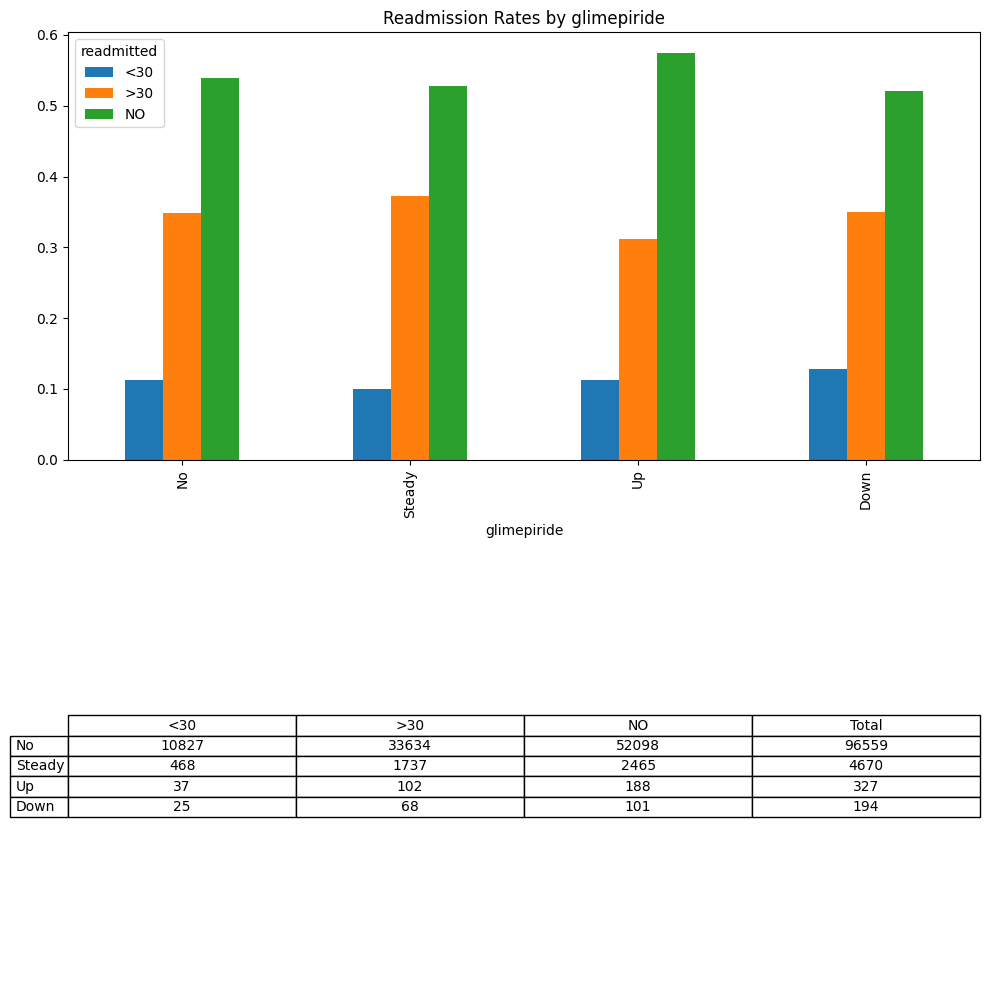

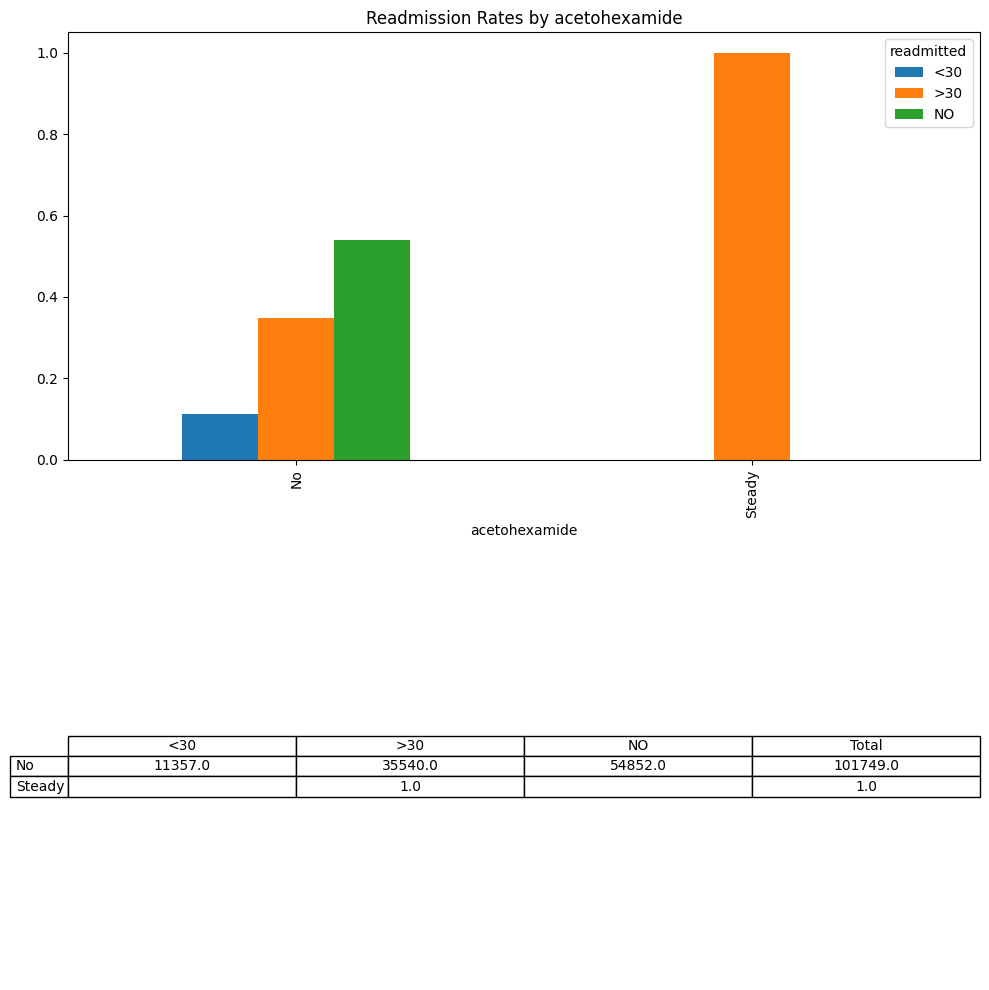

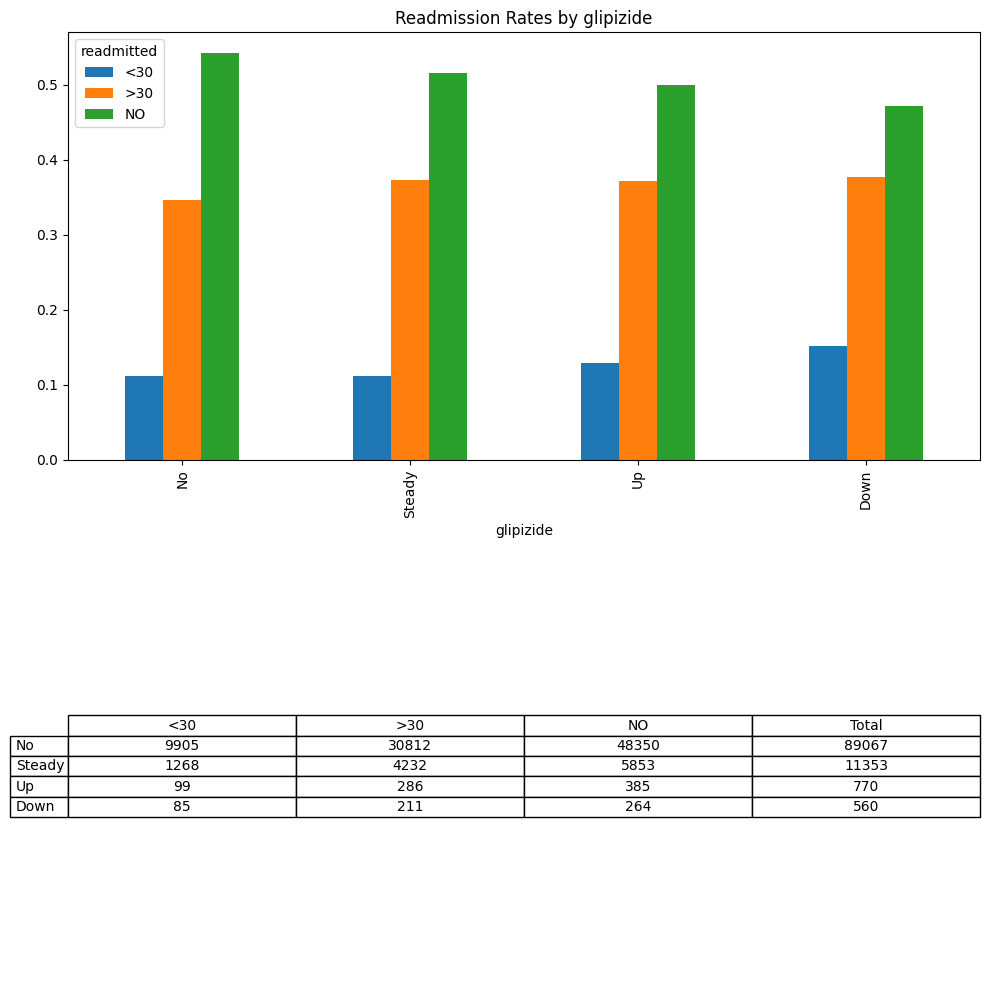

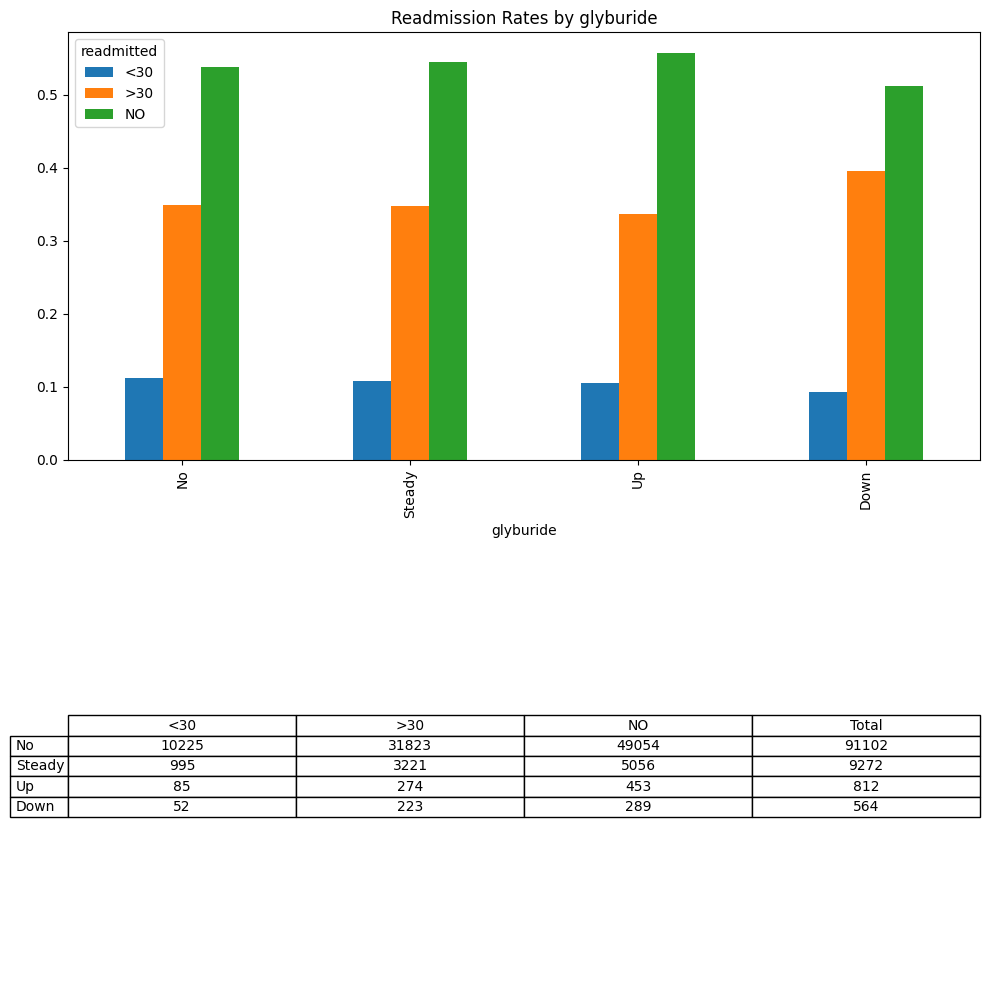

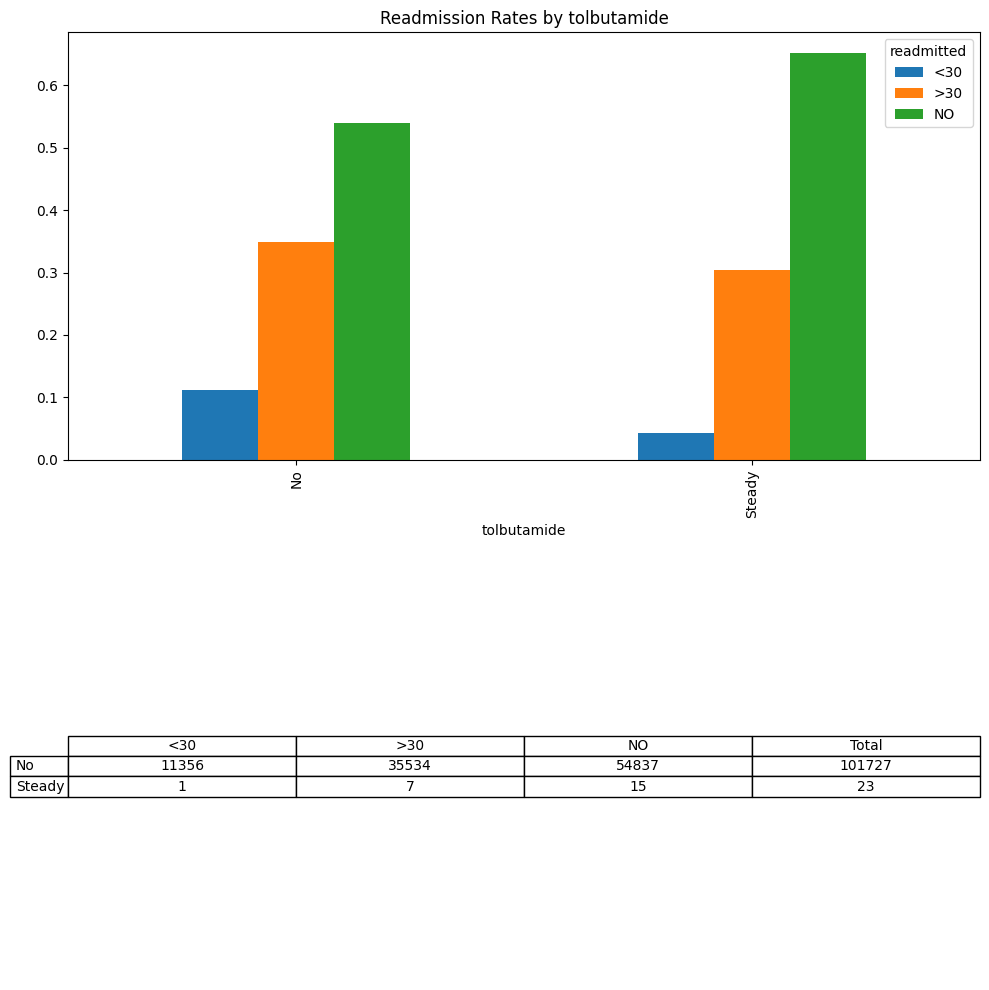

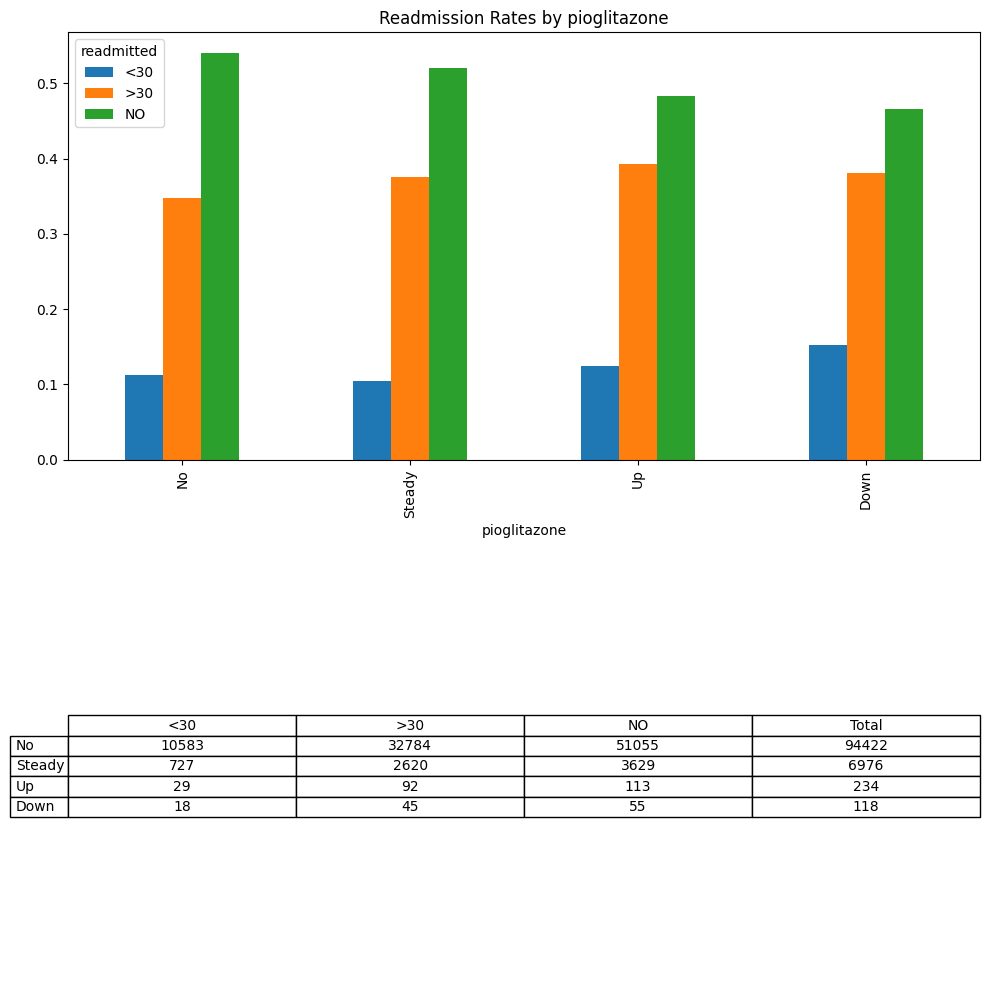

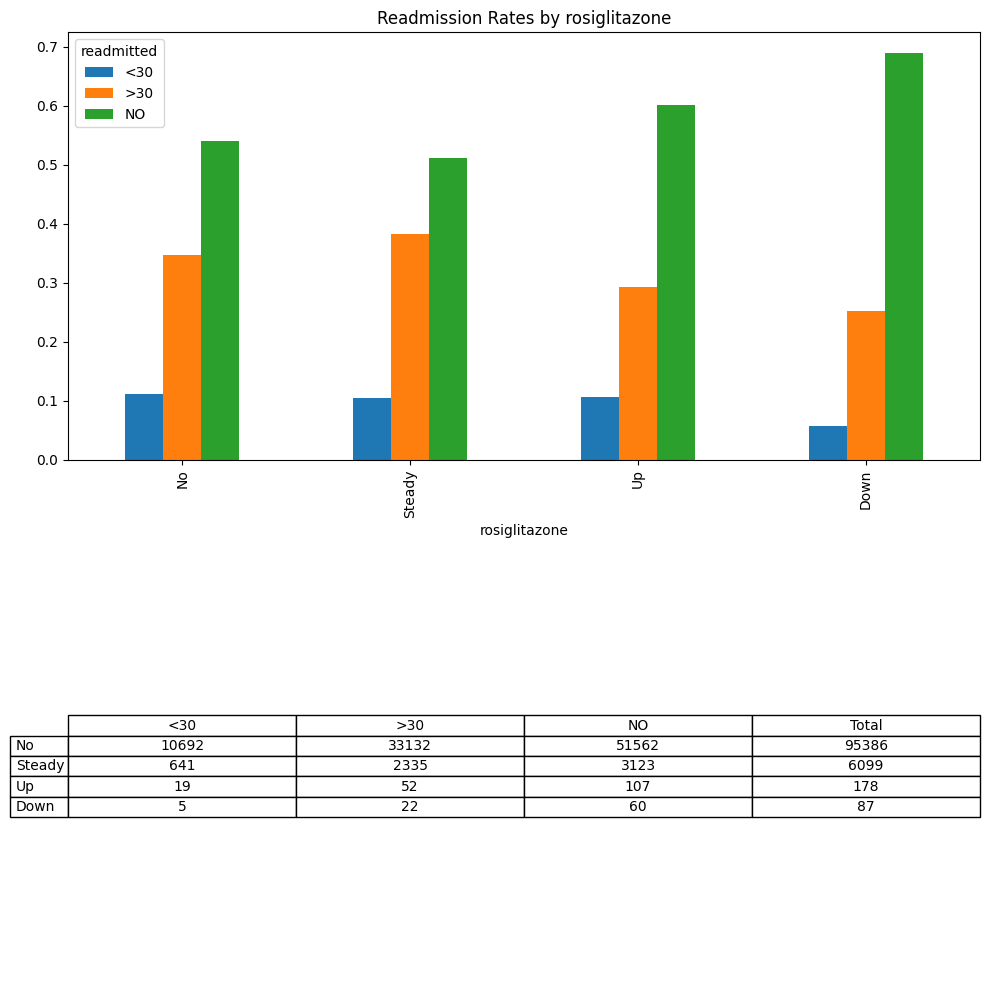

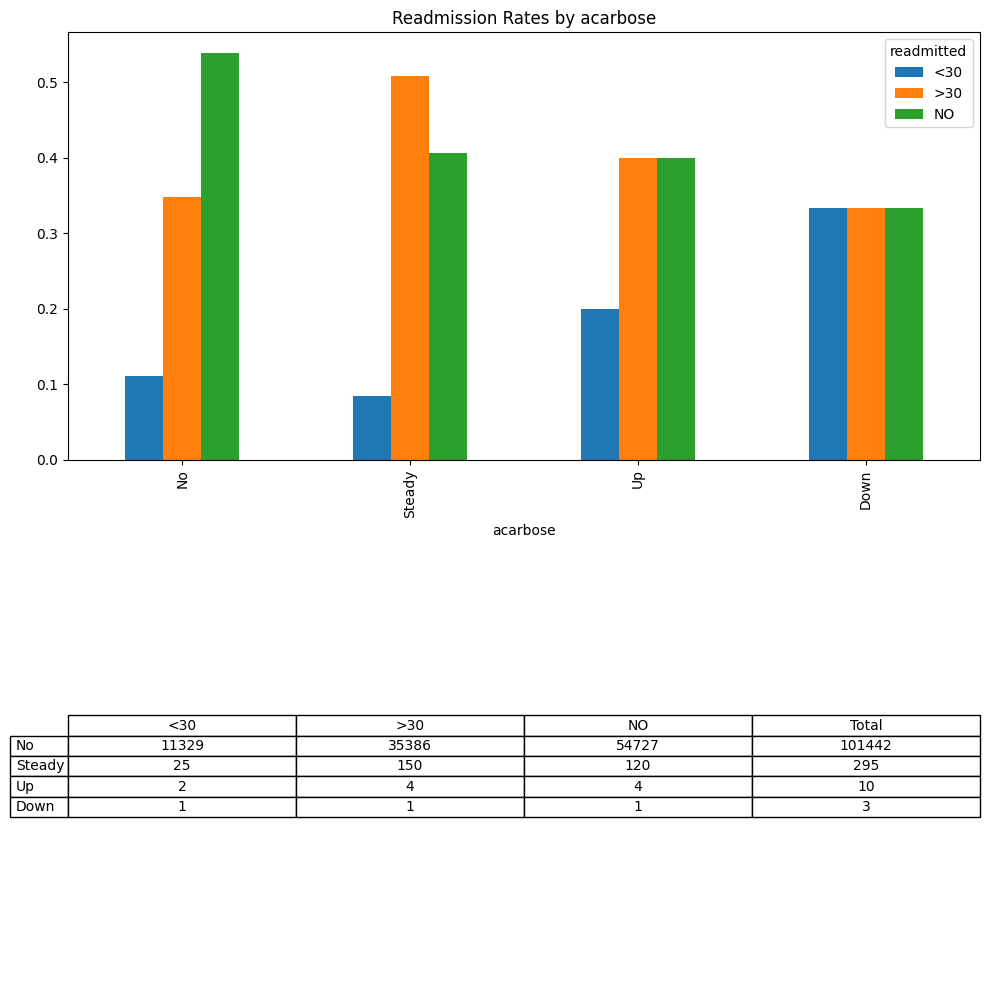

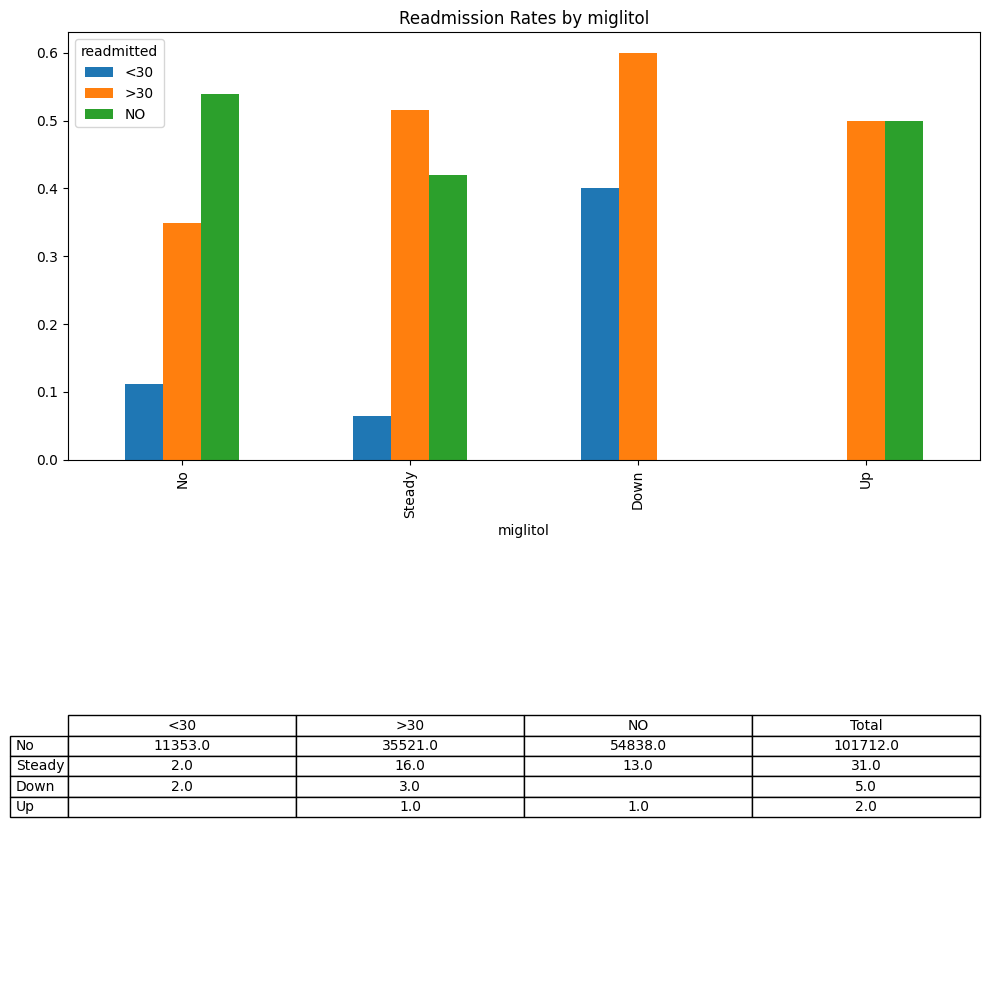

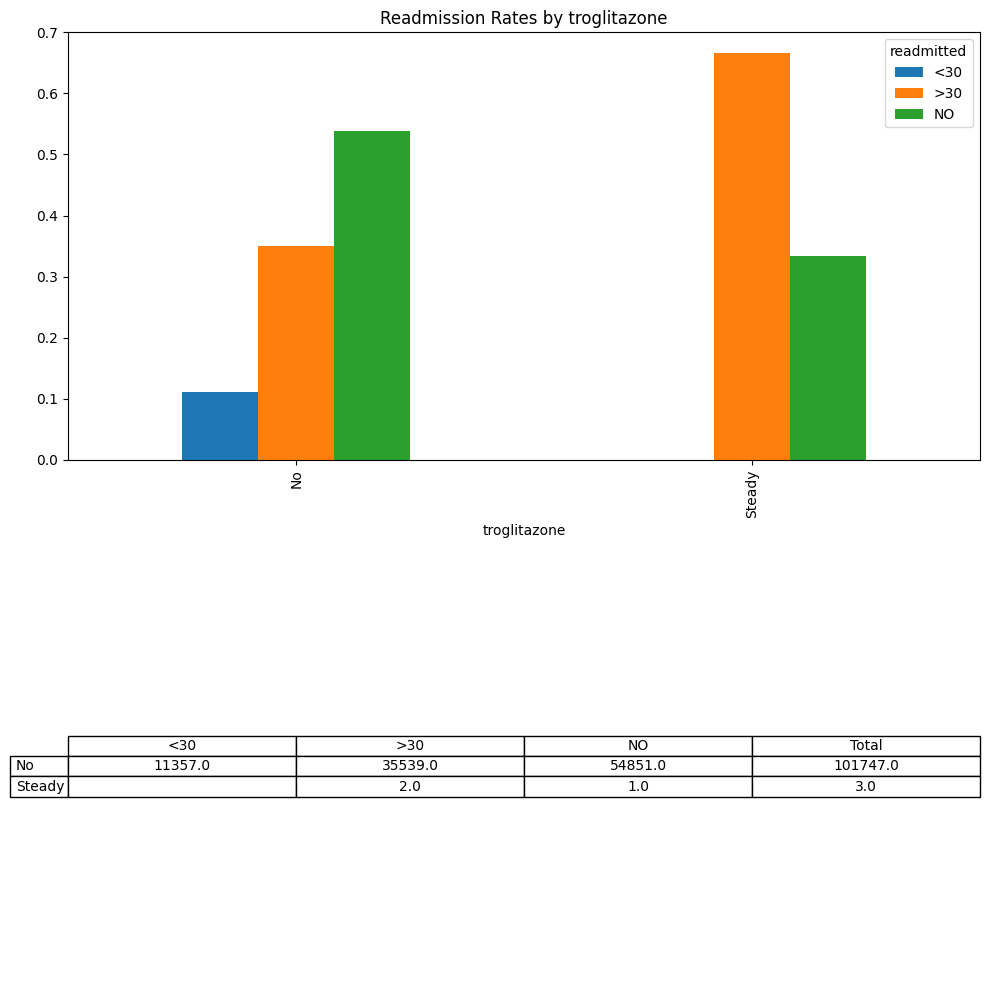

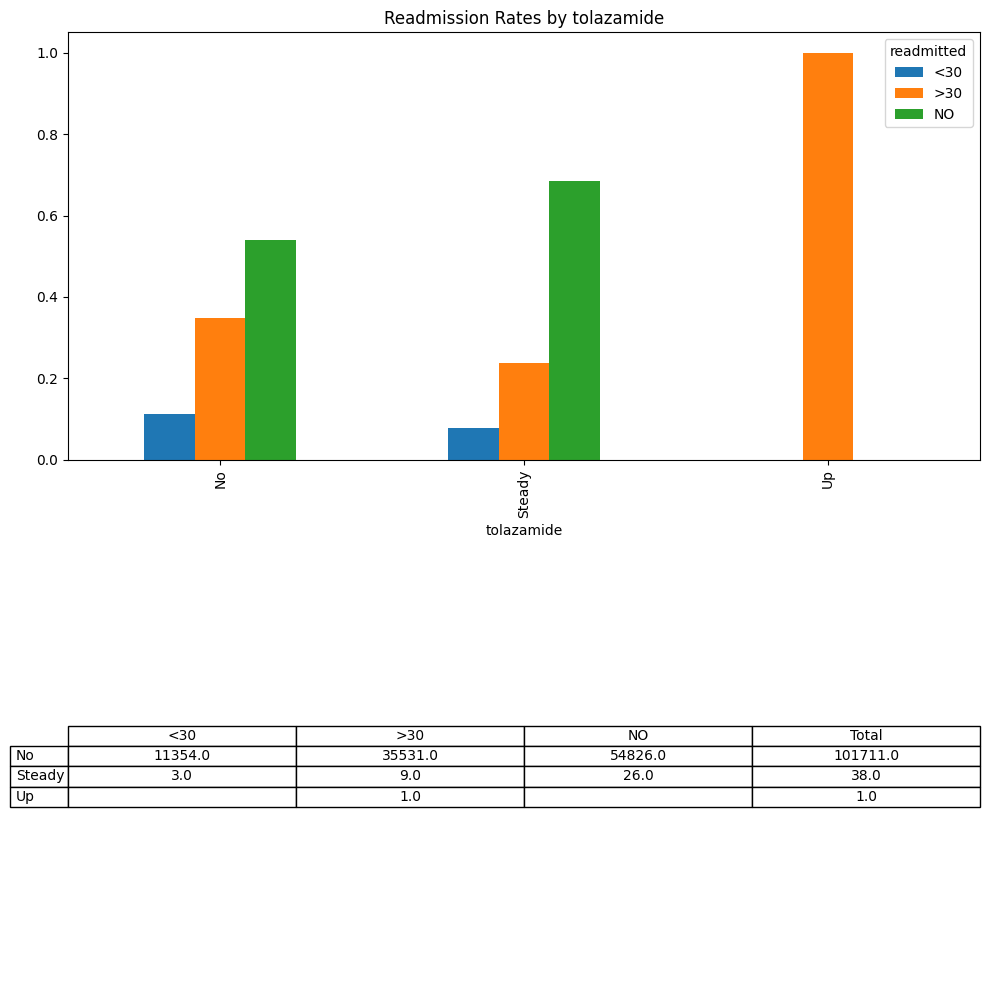

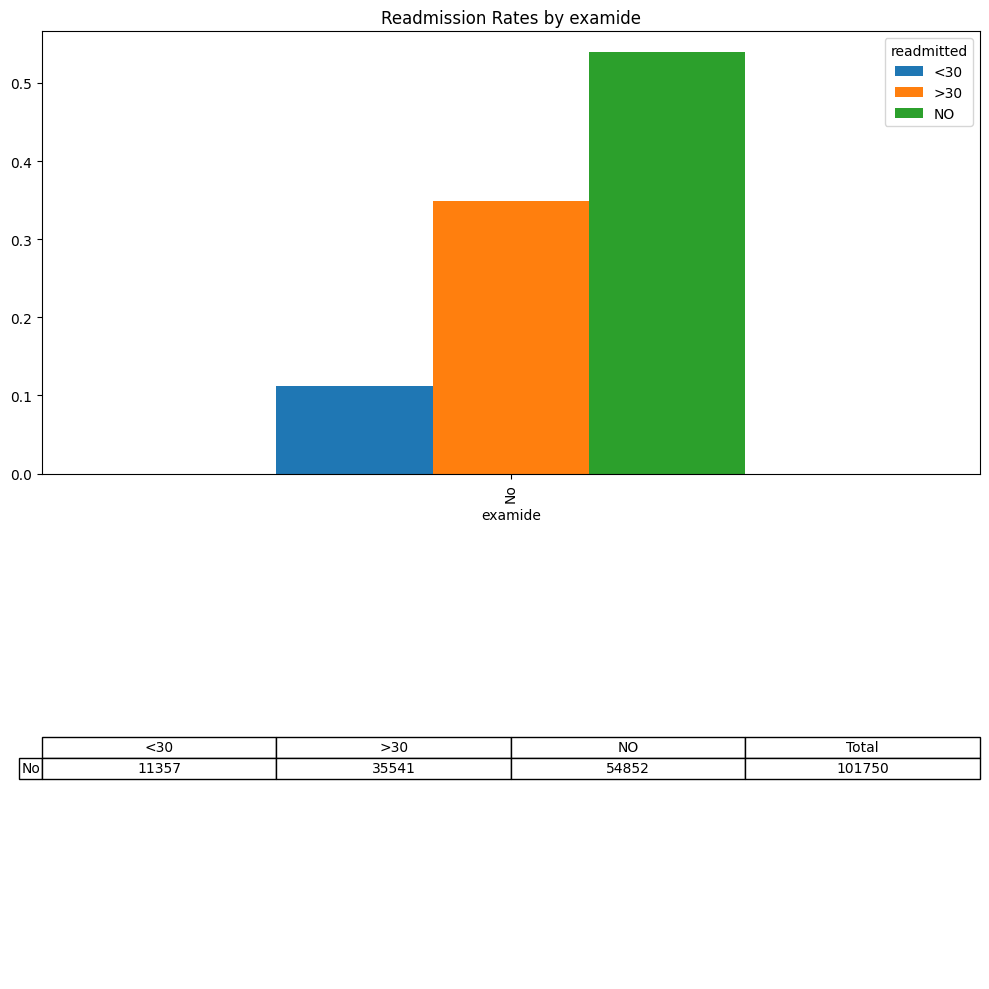

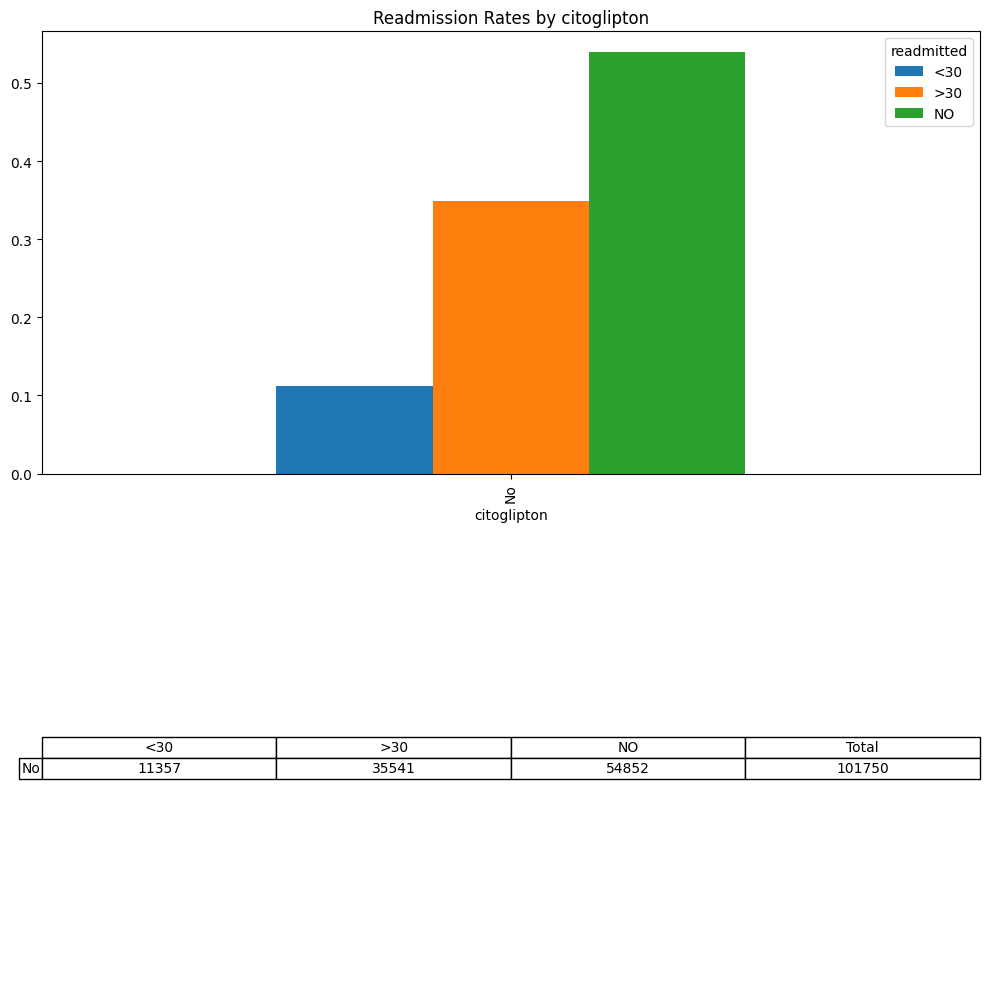

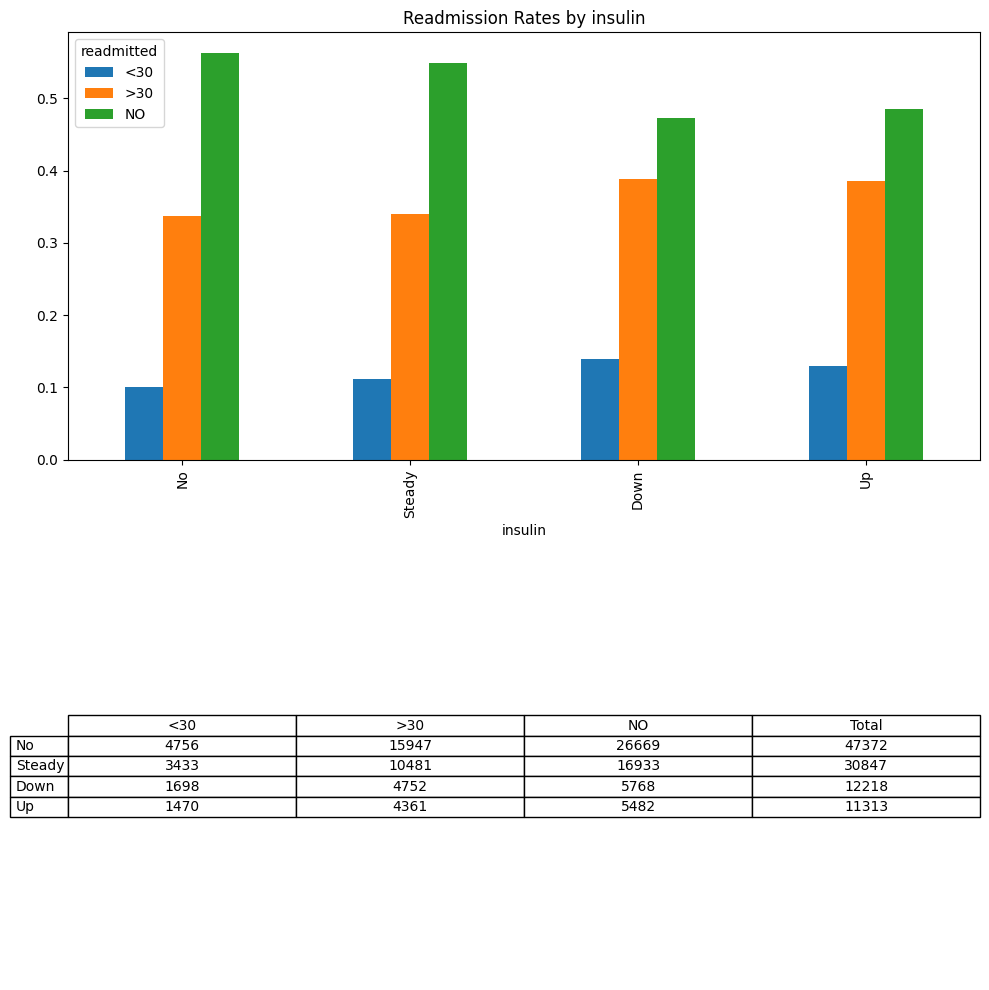

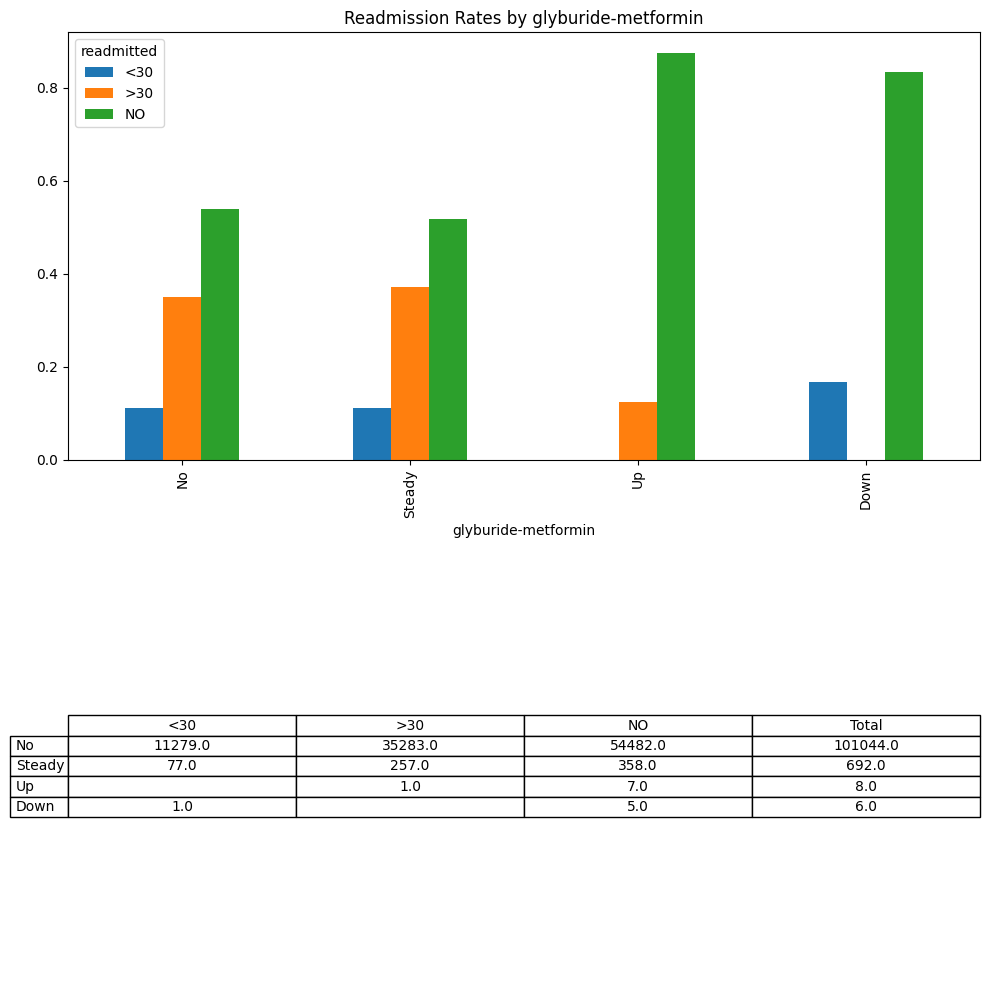

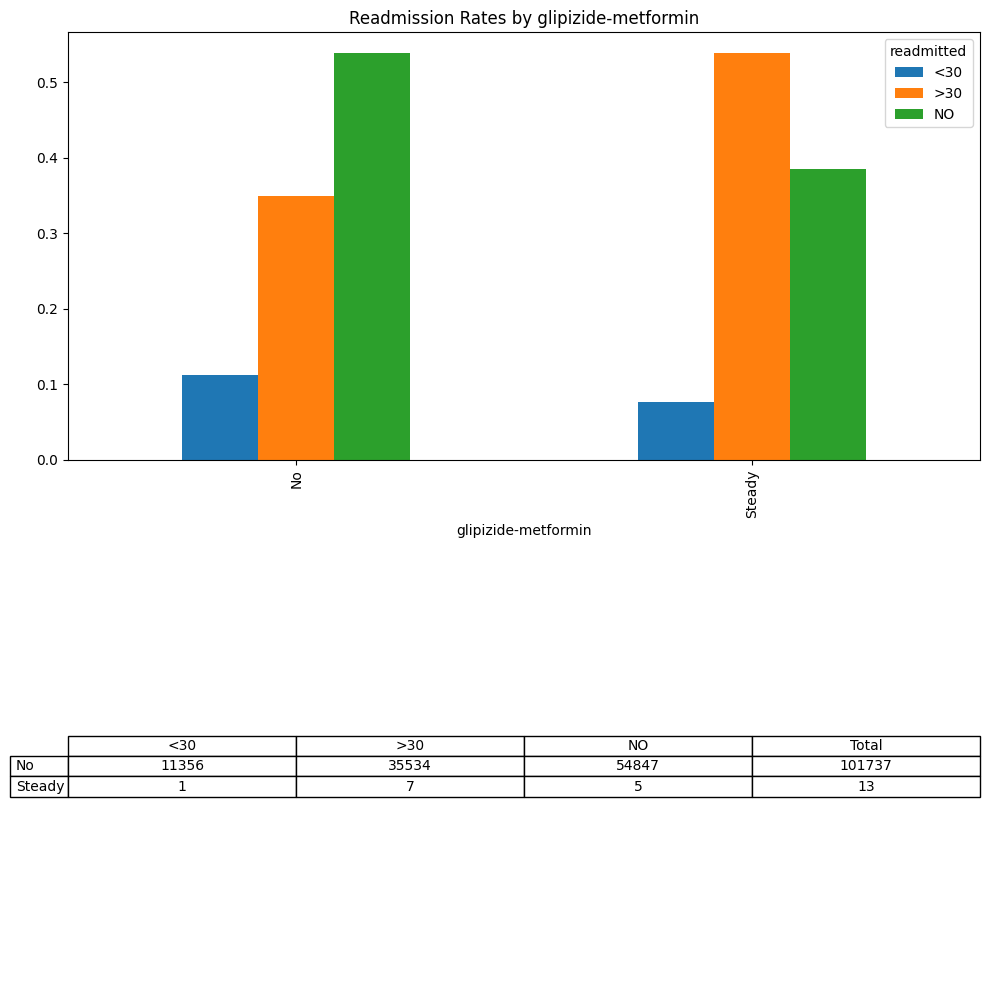

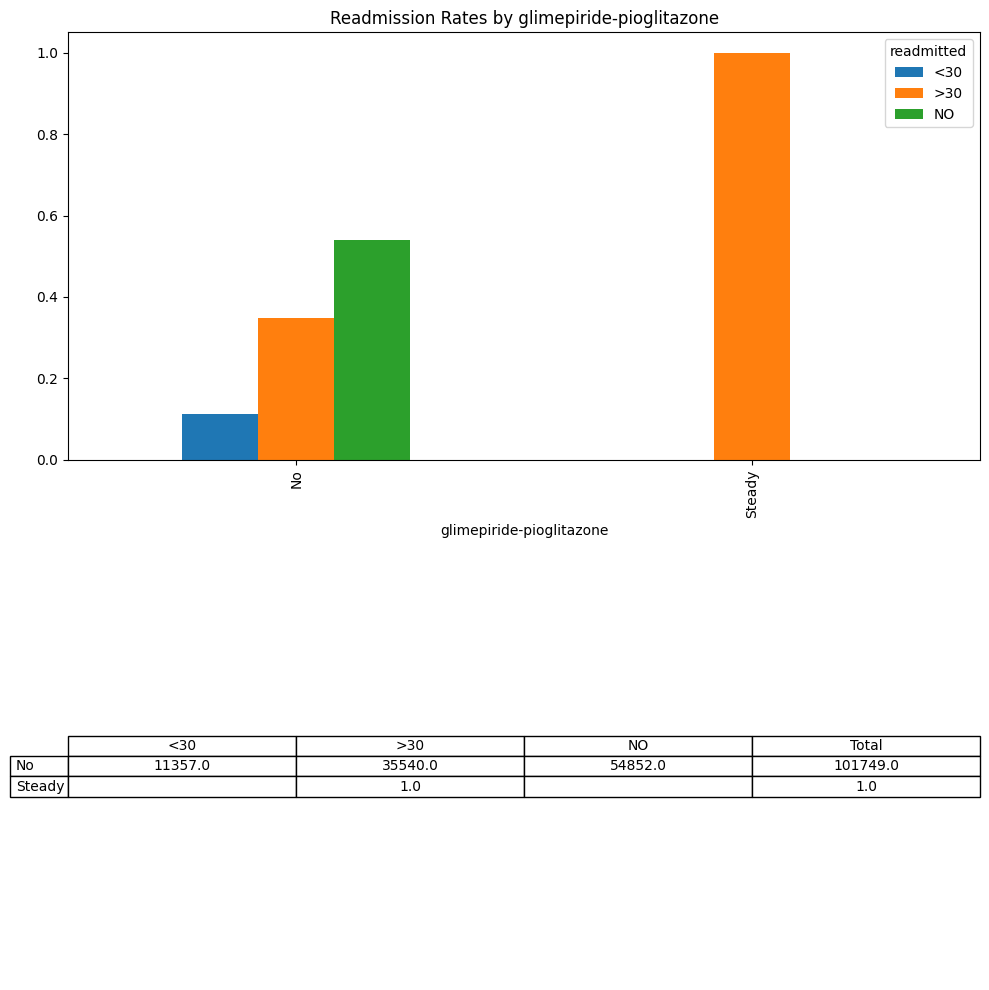

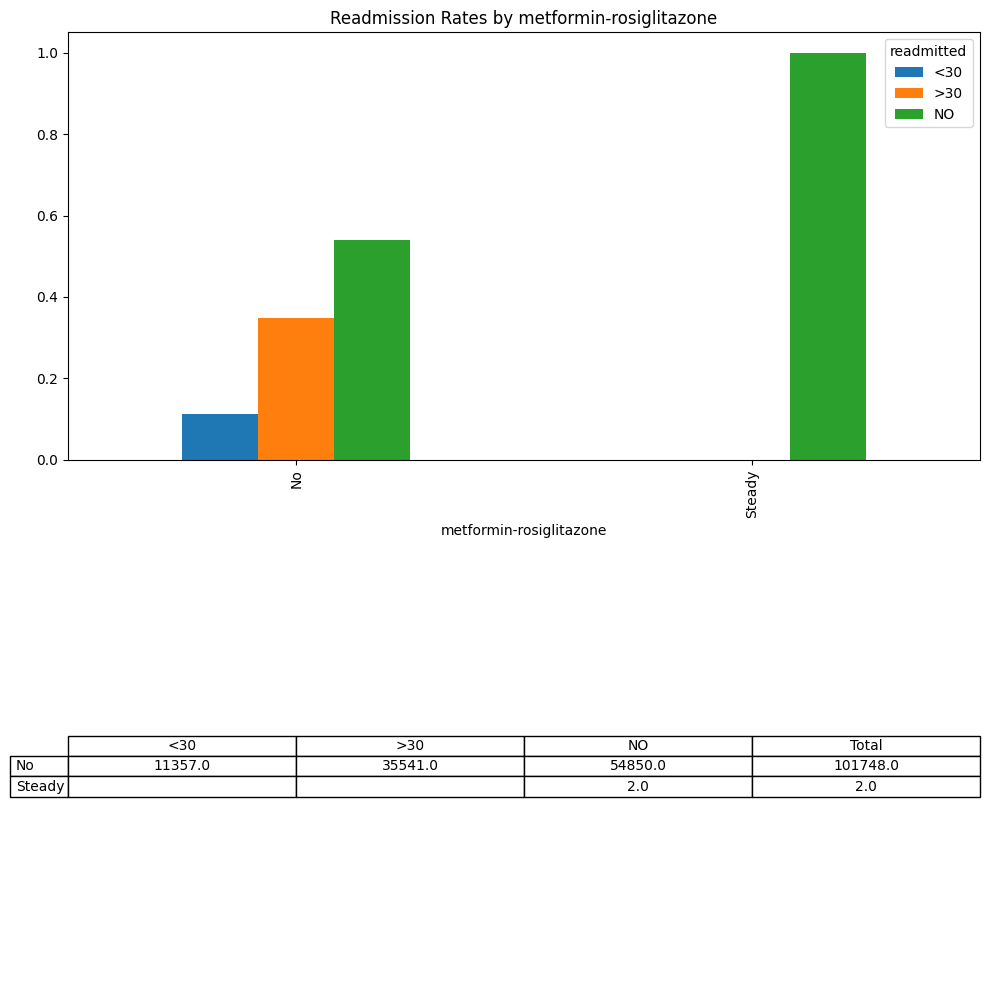

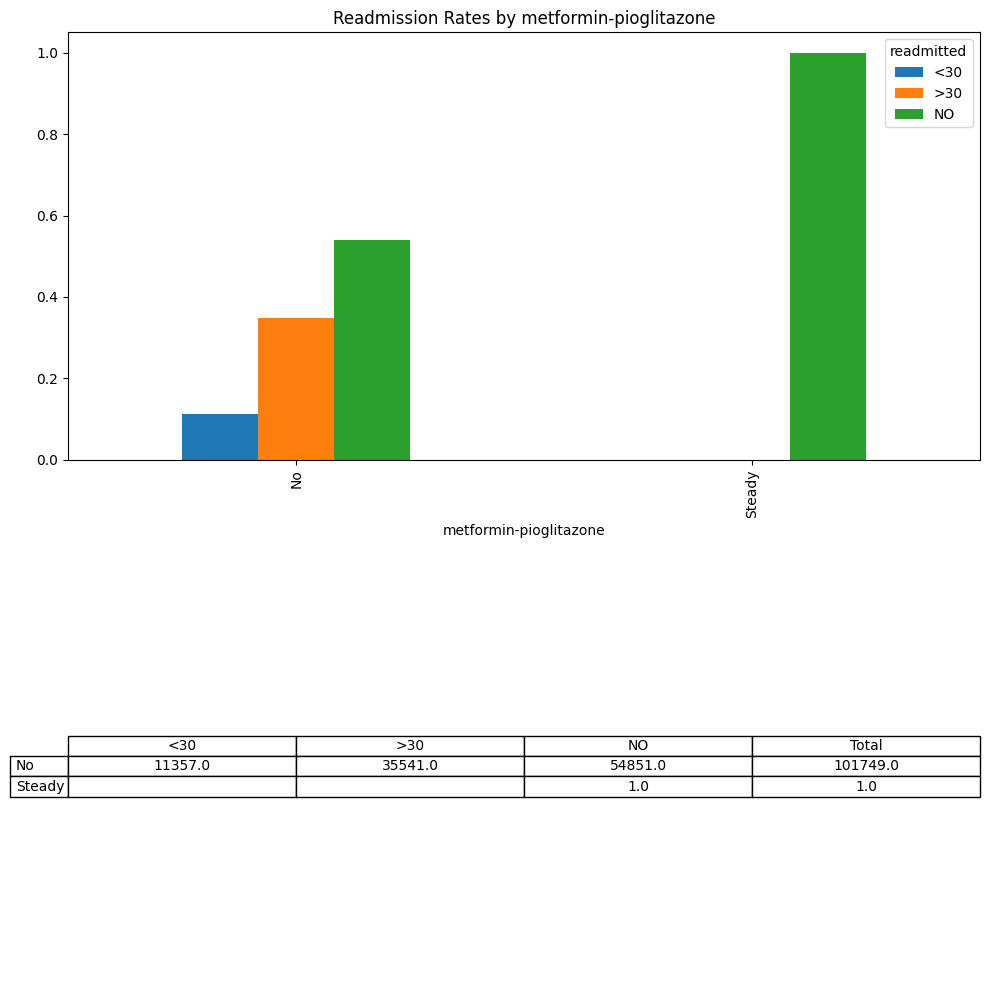

In [67]:
# Medications
medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone',]

# Loop through all medications
for col in medication_cols:
    
    # Calculate and sort counts
    counts = processed_data.groupby(col)['readmitted'].value_counts().unstack()
    counts['Total'] = counts.sum(axis=1)
    counts = counts.sort_values('Total', ascending=False)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot bar graph
    processed_data.groupby(col)['readmitted'].value_counts(normalize=True).unstack().loc[counts.index].plot(kind='bar', ax=ax1)
    ax1.set_title(f'Readmission Rates by {col}')
    
    # Create a table with total counts
    ax2.axis('off')  
    table = ax2.table(cellText=np.where(np.isnan(counts.values), '', counts.values.astype(object).astype(str)),
                  colLabels=counts.columns,
                  rowLabels=counts.index,
                  loc='center',
                  cellLoc='center')
    
    plt.tight_layout()
    plt.show()

Unfortunately, it seems that our conclusions for medication are significantly limited by the low count of patients taking any given medication, particularly some of the more complicated or modern formulations.  

Now let's take a look at the correlation heatmaps for the numerical categories as they map to predicting each of the readmission types.  

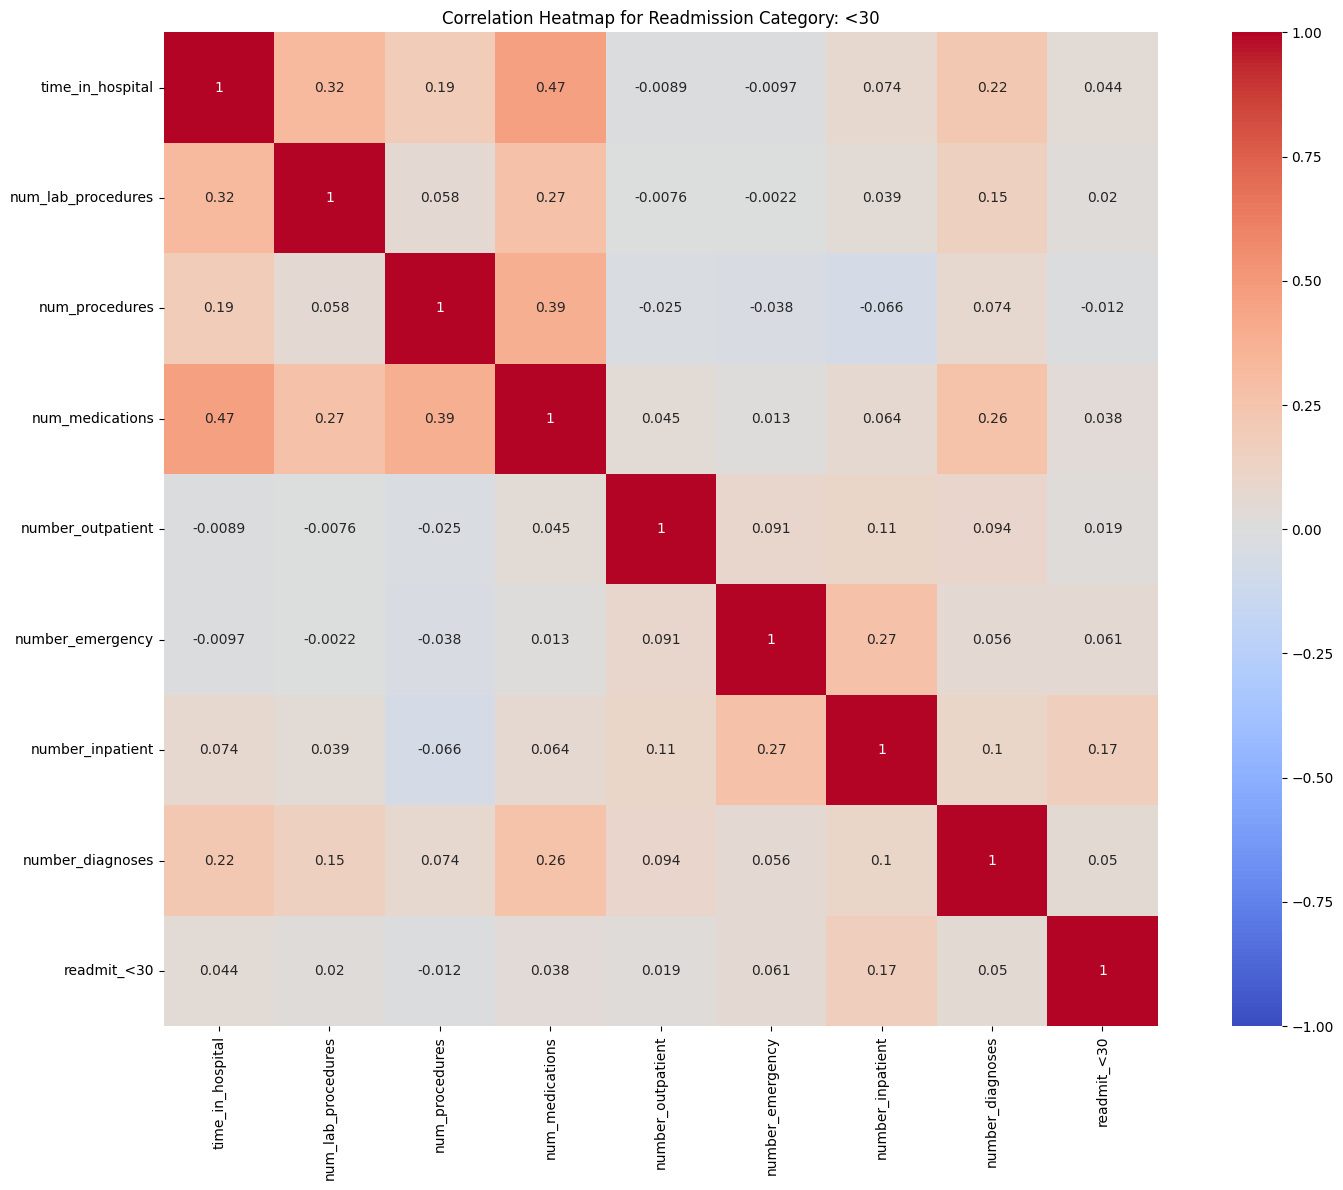


Top Correlations with Readmission:
number_inpatient      0.165149
number_emergency      0.060743
number_diagnoses      0.049516
time_in_hospital      0.044192
num_medications       0.038414
num_lab_procedures    0.020373
number_outpatient     0.018883
num_procedures        0.012205
Name: readmit_<30, dtype: float64


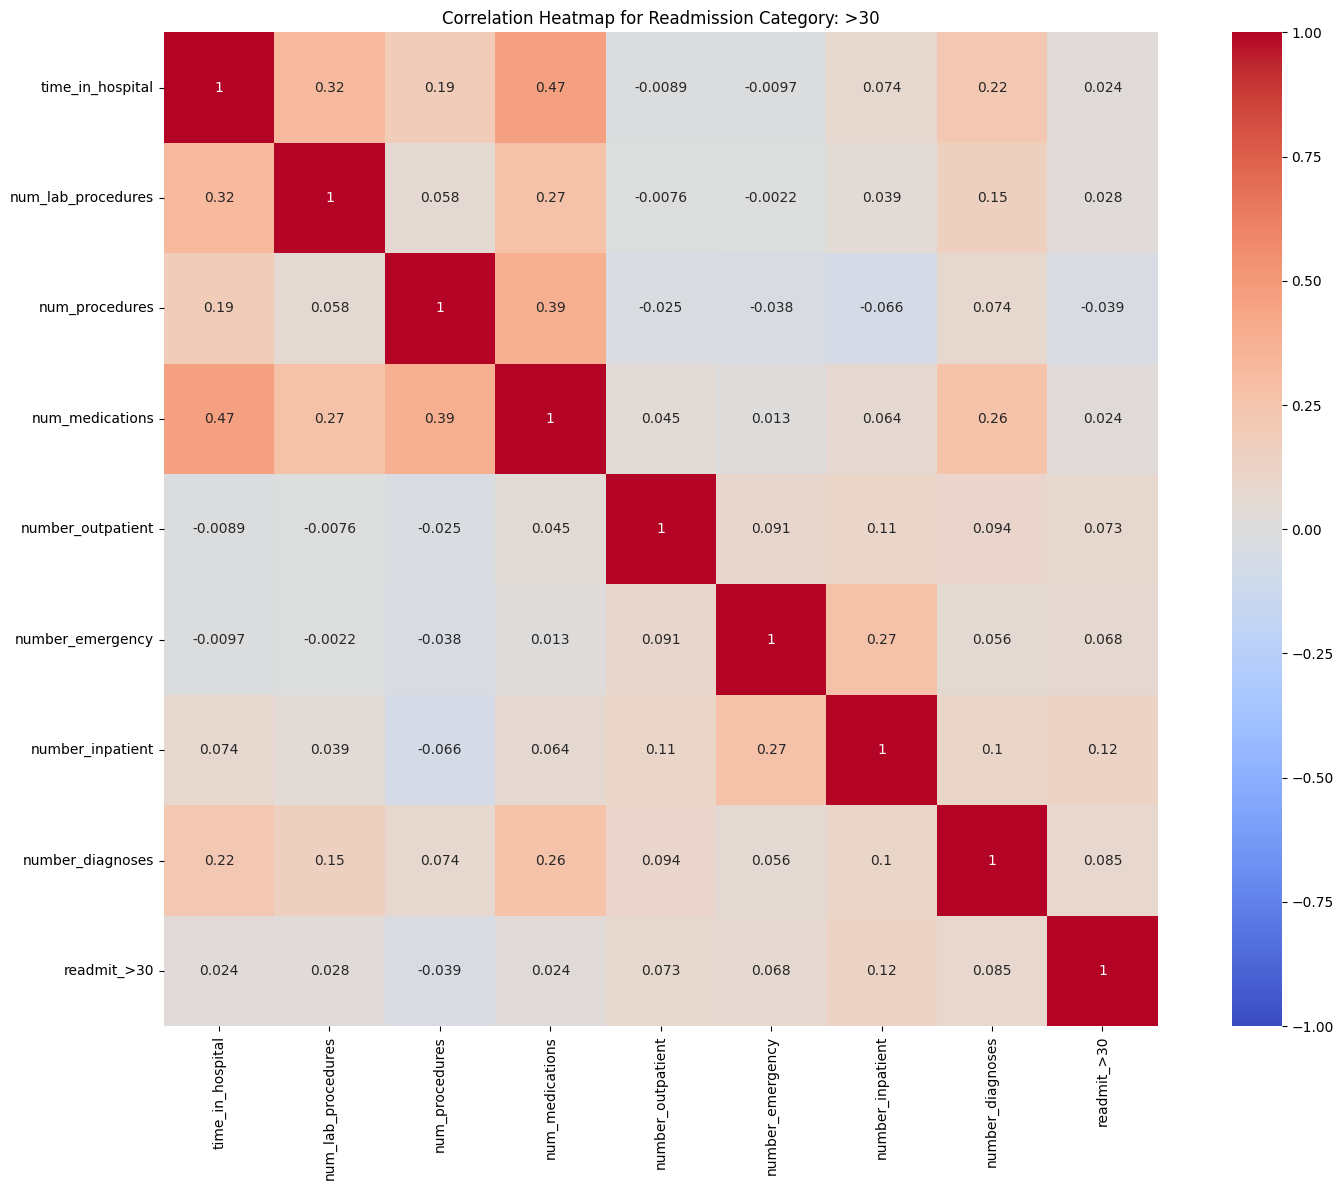


Top Correlations with Readmission:
number_inpatient      0.118026
number_diagnoses      0.085116
number_outpatient     0.073414
number_emergency      0.067597
num_procedures        0.038664
num_lab_procedures    0.027604
time_in_hospital      0.024371
num_medications       0.023512
Name: readmit_>30, dtype: float64


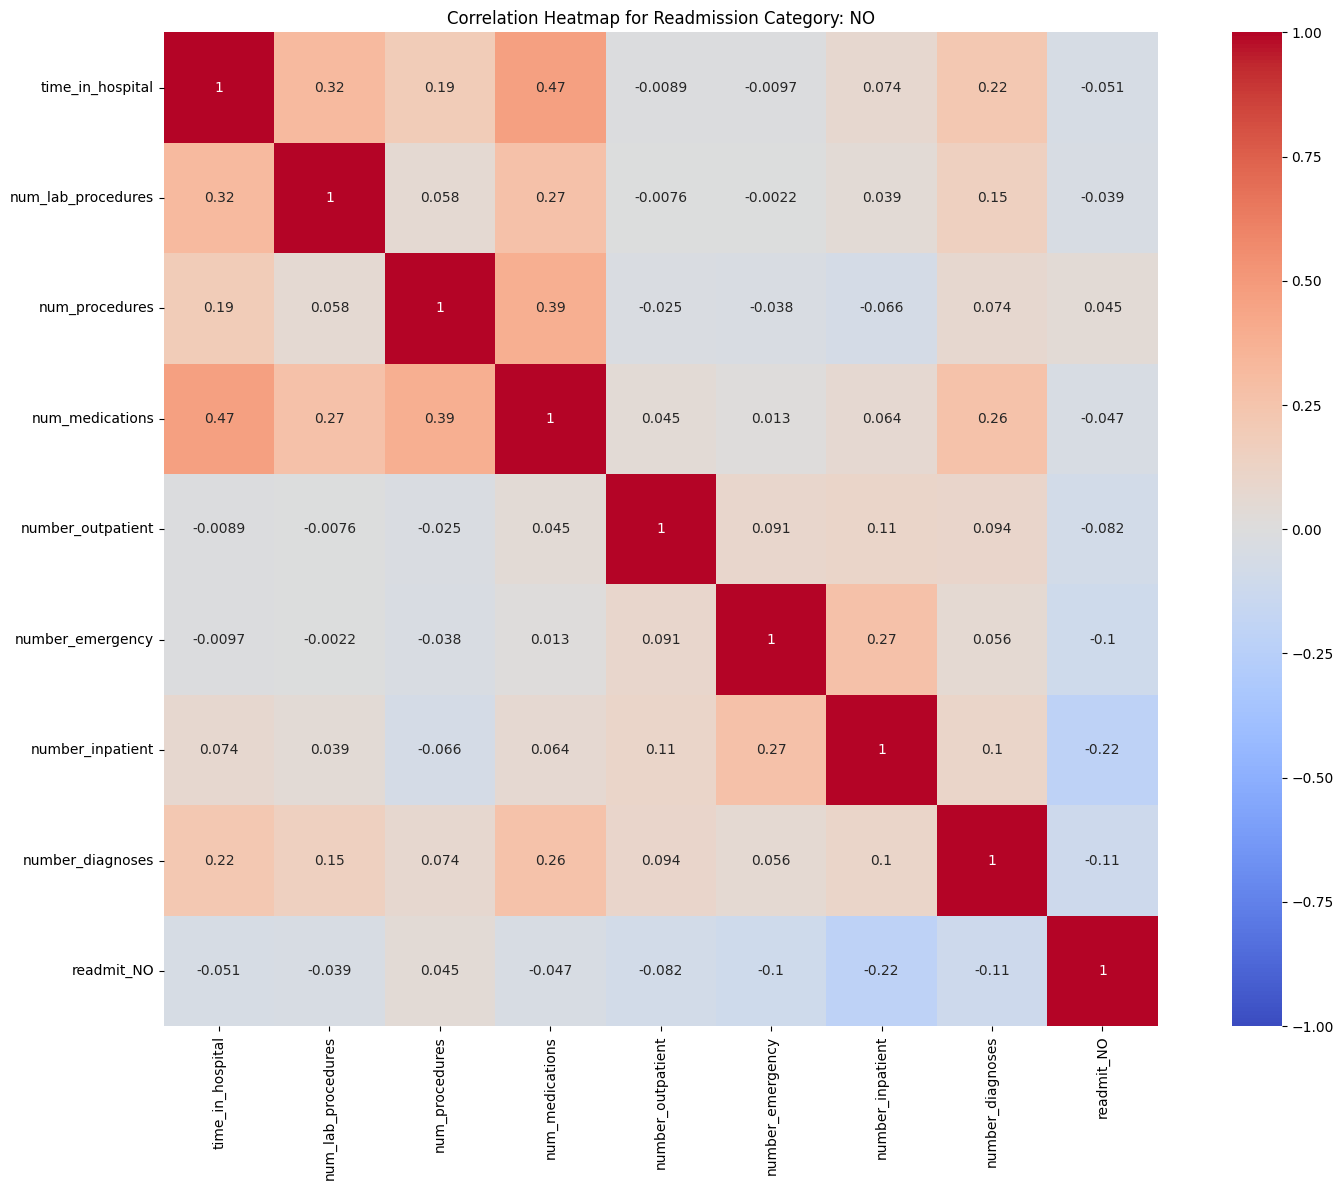


Top Correlations with Readmission:
number_inpatient      0.217211
number_diagnoses      0.112688
number_emergency      0.103025
number_outpatient     0.082143
time_in_hospital      0.051226
num_medications       0.046754
num_procedures        0.044689
num_lab_procedures    0.039271
Name: readmit_NO, dtype: float64


In [8]:
# Our potential readmission category values
readmission_categories = ['<30', '>30', 'NO']

# Loop through each category
for category in readmission_categories:
    binary_target = (processed_data['readmitted'] == category).astype(int)
    
    # Prepare numerical data
    numerical_data = processed_data[numerical_cols]
    
    # Correlation analysis
    correlation_data = pd.concat([numerical_data, pd.Series(binary_target, name=f'readmit_{category}')], axis=1)
    correlation_matrix = correlation_data.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(16,12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                vmin=-1, vmax=1, square=True)
    plt.title(f'Correlation Heatmap for Readmission Category: {category}')
    plt.tight_layout()
    plt.show()

    # Print out highest values, removing spot 0 (self-correlation)
    readmit_correlations = correlation_matrix[f'readmit_{category}'].abs().sort_values(ascending=False)
    print("\nTop Correlations with Readmission:")
    print(readmit_correlations[1:11]) 


Here, we seem to see that the number of days a patient spent in inpatient has the strongest correlation in all three categories, but ultimately the values across the board are fairly close to zero for pretty much all data points in all cases. 

Let's create a Random Forest classifier and look at our prediction accuracy and feature importance.  

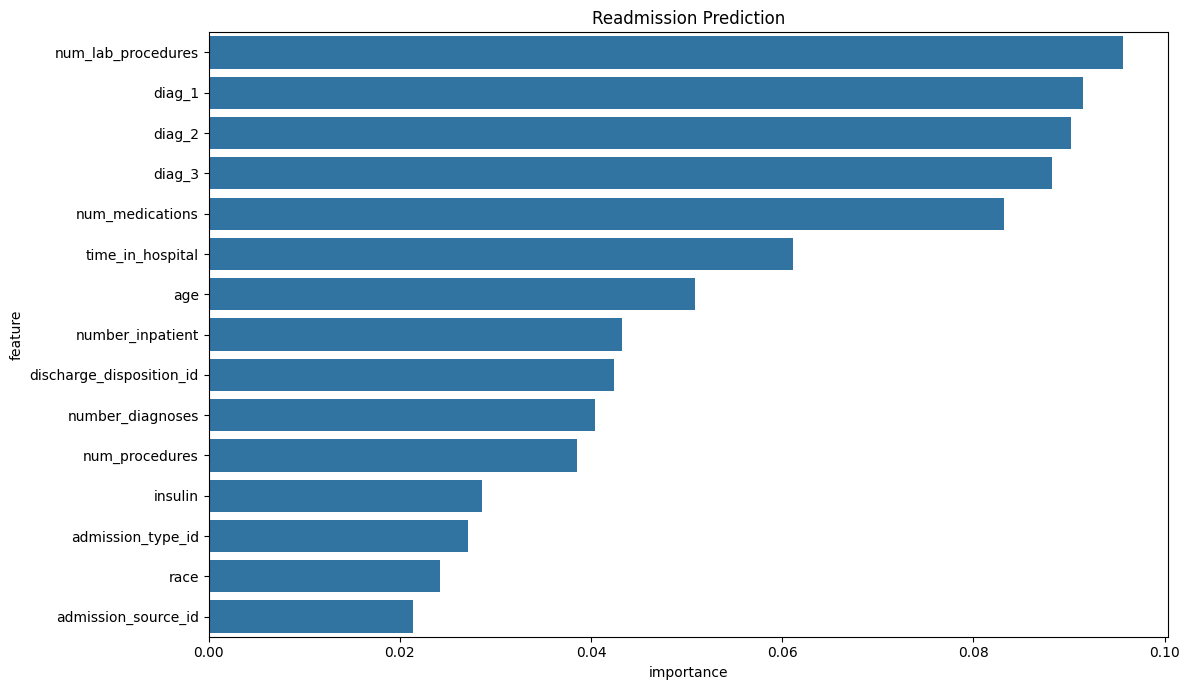


Features for Readmission:
                 feature   importance
      num_lab_procedures 9.562993e-02
                  diag_1 9.145770e-02
                  diag_2 9.026059e-02
                  diag_3 8.817913e-02
         num_medications 8.322358e-02
        time_in_hospital 6.117021e-02
                     age 5.092867e-02
        number_inpatient 4.320295e-02
discharge_disposition_id 4.239356e-02
        number_diagnoses 4.044342e-02
          num_procedures 3.855161e-02
                 insulin 2.862712e-02
       admission_type_id 2.716372e-02
                    race 2.421769e-02
     admission_source_id 2.142462e-02
                  gender 2.010408e-02
               A1Cresult 1.850351e-02
       number_outpatient 1.834982e-02
        number_emergency 1.470105e-02
               metformin 1.424260e-02
               glipizide 1.375791e-02
                  change 1.360819e-02
               glyburide 1.218017e-02
            pioglitazone 9.168642e-03
             diabetesMe

In [19]:
# Label encode target variable
le = LabelEncoder()
processed_data_fit = processed_data.copy()
processed_data_fit['fit'] = le.fit_transform(processed_data_fit['readmitted'])

# Label encode the object columns
for col in processed_data_fit.select_dtypes(include=['object']).columns:
    processed_data_fit[col] = le.fit_transform(processed_data_fit[col].astype(str))

# Remove excess columns from X, and declare y as 'fit'
X = processed_data_fit.drop(['readmitted', 'fit'], axis=1)
y = processed_data_fit['fit']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train RF
rf = RandomForestClassifier( n_estimators=100, random_state=1 )
rf.fit(X_train, y_train)

# Calculate feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12,7))
sns.barplot(x='importance', y='feature', data=importance.head(15))
plt.title('Readmission Prediction')
plt.tight_layout()
plt.show()

# Print out feature importance information
print("\nFeatures for Readmission:")
print(importance.to_string(index=False))

# Predict and print out classifcation report
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Overall, we can see from the initial exploration into the data that we have several problems.  

The data ultimately does not have very clear-cut correlation between any of our data points and readmission rates. 

Our correlation values are very low, as shown in our heatmap.  Interestingly, even HbA1c, the test result that the paper is based on, has a very low correlation, not even in the top 10 values.

Our random forest model performs poorly. Particularly notable is our absolutely terrible recall for predicting <30 days of readmission at .02, and overall we are at quite a poor precision and recall, below 60%. Let's see how we can improve this. 

While Num_Lab_Procedures was the most significant in terms of feature importance in our model, nothing is greater than .1 and thus highly signficant.  However, when looking more deeply at the Diagnosis data, we can see that there is a good bit more information we can potentially extract; there are repeated values across Diag_1-3, so if we explode the data out into individual major diseases we can hopefully extract a clearer perspective.  

Let's try a bit of feature engineering with the diagnosis data.

Feature Engineering:

First, let's find the most common disease codes across all three diagnosis columns.  

Additionally, we want to drop any codes that start with E or V, as those correspond to External injury/accidents and Supplementary Circumstances, respectively.  Since these codes should not correspond to underlying medical issues, these data points will only add noise and make it harder to process our data as is.  

In [ ]:
# Melt the diagnoses into one column called value, dropping any NA values or non-numeric values
combined_diags = processed_data[['diag_1', 'diag_2', 'diag_3']].melt(value_name='value')
combined_diags["value"] = pd.to_numeric(combined_diags["value"], errors = 'coerce')
combined_diags = combined_diags.dropna(subset=['value'])

# Calculate the value_counts from our new combined_diags column and sort
value_counts = combined_diags['value'].value_counts()
value_counts = value_counts.sort_values(ascending=False)

# Show our top 10 values, total diagnosis values, and total unique diagnoses
print(value_counts.head(10), "\n", "sum: ",  sum(value_counts), "size: ", value_counts.size)

value
428.0    18098
250.0    17860
276.0    13815
414.0    12895
401.0    12370
427.0    11754
599.0     6824
496.0     5989
403.0     5693
486.0     5454
Name: count, dtype: int64 
 sum:  294210 size:  781


We can see that we have 781 unique diagnoses comprising of 294210 complete diagnoses.  

In the ICD-9 medical coding language, 250 represents the ICD code for Diabetes.  Values of 250.XX are subsets of 250; i.e. 250.02 is Type 2 Diabetes Mellitus with Hyperglycemia, while 250.6 is Diabetes with Neurological Manifestations. 

For our purposes, let's trim off any supplemental code numbers and look at the top level of diagnosis for now to see if we can generate any additional clarity.

In [ ]:
# Copy our dataframe
joined_df = combined_diags.copy()

# Trim any floating point numbers down to int 
joined_df["value"] = joined_df["value"].astype(int)

# Calculate the value_counts and sort
int_val_counts = joined_df['value'].value_counts()
int_val_counts = int_val_counts.sort_values(ascending=False)

#Show new most commmon and most changed values
print(int_val_counts.head(10))
print((int_val_counts-value_counts).sort_values(ascending=False))

value
250    38703
428    18098
276    13815
414    12895
401    12370
427    11754
599     6824
496     5989
403     5693
486     5454
Name: count, dtype: int64
value
250.00    20843.0
365.00        1.0
3.00          0.0
685.00        0.0
670.00        0.0
           ...   
250.90        NaN
250.91        NaN
250.92        NaN
250.93        NaN
365.44        NaN
Name: count, Length: 781, dtype: float64


It appears that only Diabetes made any significant increase by dropping subsets. Since this dataset is run on patients with diabetes to begin with, this data point is actually a loss of information for each patient, and thus it seems there is no advantage in not proceeding with our original diag types rather than using this new dataframe, as it does not seem to simplify our data set in a useful way. 

Let's redo our Random Forest Classifier with our diagnosis data and our two best other columns, num_lab_procedures and num_medications. 

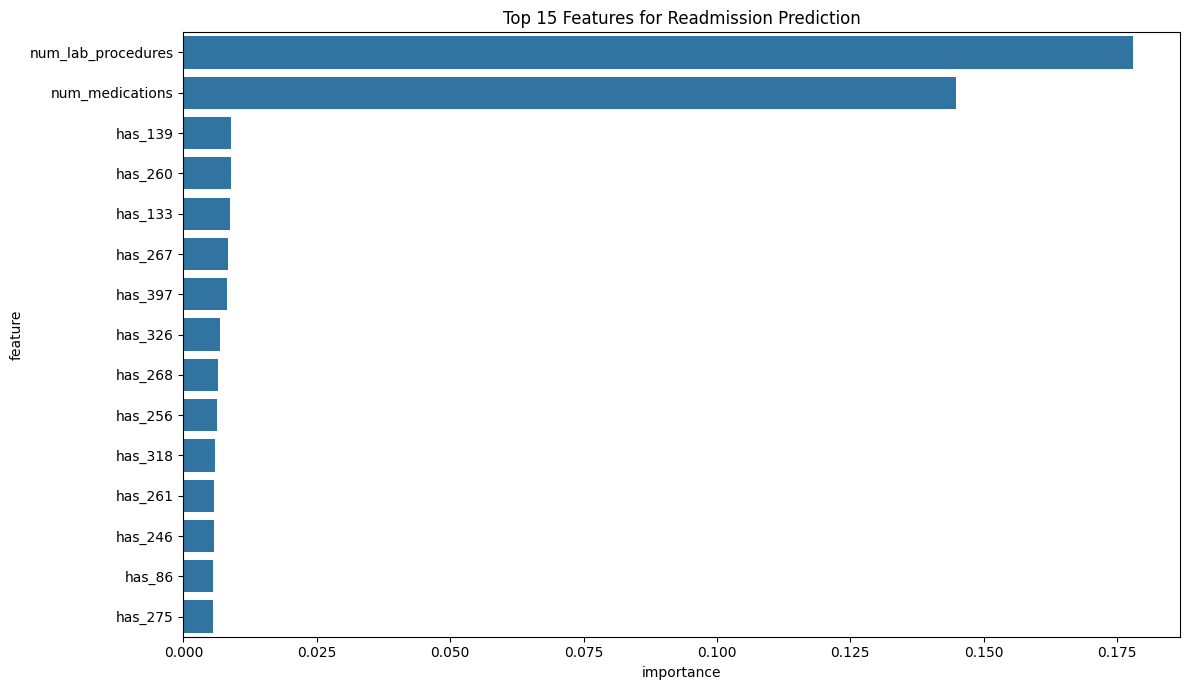


Top 15 Features for Readmission:
           feature  importance
num_lab_procedures    0.177915
   num_medications    0.144901
           has_139    0.008929
           has_260    0.008919
           has_133    0.008818
           has_267    0.008329
           has_397    0.008082
           has_326    0.006873
           has_268    0.006543
           has_256    0.006285
           has_318    0.005896
           has_261    0.005675
           has_246    0.005654
            has_86    0.005634
           has_275    0.005575

Classification Report:
              precision    recall  f1-score   support

         <30       0.17      0.03      0.05      2309
         >30       0.41      0.28      0.33      7155
          NO       0.56      0.78      0.65     10886

    accuracy                           0.52     20350
   macro avg       0.38      0.36      0.35     20350
weighted avg       0.47      0.52      0.47     20350


Detailed Readmission Analysis for Top Diagnosis Features:


In [97]:
# Diagnosis columns
diags = ['diag_1', 'diag_2', 'diag_3']

# Label encode target variable
le = LabelEncoder()
processed_data_diags = processed_data.copy()
processed_data_diags['fit'] = le.fit_transform(processed_data_diags['readmitted'])

# Label encode the object columns
for col in processed_data_diags.select_dtypes(include=['object']).columns:
    processed_data_diags[col] = le.fit_transform(processed_data_diags[col].astype(str))
    
# Create unique list of diagnoses in terms of ICD code
unique_diagnoses = set()
for col in diags:
    unique_diagnoses.update(processed_data_diags[col].dropna().unique())    
    
# Create a dataframe with columns has_x with row values of 0 or 1
has_diags = pd.DataFrame({
    f'has_{diagnosis}': ((processed_data_diags['diag_1'] == diagnosis) |
                         (processed_data_diags['diag_2'] == diagnosis) |
                         (processed_data_diags['diag_3'] == diagnosis)).astype(int)
    for diagnosis in unique_diagnoses
})

# Combine all processed columns
processed_data_final = pd.concat([has_diags, processed_data_diags['fit'], processed_data_diags['num_lab_procedures'], 
                                  processed_data_diags['num_medications']], axis=1)

# Prepare X features and target y
X = processed_data_final.drop('fit', axis=1)
y = processed_data_final['fit']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train Random Forest Classifier
rf = RandomForestClassifier( n_estimators=100, random_state=1, class_weight='balanced' )
rf.fit(X_train, y_train)

# Calculate feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12,7))
sns.barplot(x='importance', y='feature', data=importance.head(15))
plt.title('Top 15 Features for Readmission Prediction')
plt.tight_layout()
plt.show()

# Print feature importance
print("\nTop 15 Features for Readmission:")
print(importance.head(15).to_string(index=False))

# Predict, print classification report
y_pred = rf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Detailed analysis of top diagnosis features
print("\nDetailed Readmission Analysis for Top Diagnosis Features:")
top_features = importance[
    importance['feature'].str.startswith('has_') & 
    (importance['importance'] > 0)
].head(10)['feature'].tolist()

Well, that's even worse. Our random forest classifier's accuracy has dropped even further down. 

Unfortunately, it appears as though the feature engineering attempt we made will not work.  

Let's instead try using some different models and a few numerical tricks to see if we can improve our accuracy.  

Firstly, let's adjust the weights and use imbalanced learn's SMOTE pipeline to get a more even distribution between our minority and majority classes.  

Secondly, let's try using a few different models to get a different sense of our predictions.  We'll use Logistic Regression, Adaboost, and Gradient Boost, and also the Random Forest we were using from before as a comparison as to how much changing our weight and classes does.  

In [16]:
# Take the initial processed data and convert it to X and y
X = processed_data.drop('readmitted', axis=1)
y = processed_data['readmitted']

# Label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Adjust class weights to balance our classes
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Transformers to fit the data to the various models as necessary, to avoid errors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor using the transfomers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Our Four Model Pipelines
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=.1, class_weight=class_weight_dict, max_iter=1000))
    ]),
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(random_state=1))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(random_state=1))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=1, class_weight=class_weight_dict))
    ])
}

# Use SMOTE to over-sample the minority classes to try to improve our accuracy in <30 readmissions.  
smote = SMOTE(random_state=1)
for name in models:
    models[name] = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', models[name].named_steps['classifier'])
    ])


In [17]:
# Train and evaluate models
results = {}

for name, model in models.items():
    # Fit the model
    print(f"Fitting {name}")
    model.fit(X_train, y_train)
    
    # Predictions
    print(f"Predicting for {name}")
    y_pred = model.predict(X_test)
    
    # Evaluation metrics
    results[name] = {
        'Classification Report': classification_report(y_test, y_pred),
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Accuracy Score': accuracy_score(y_test, y_pred),
        'y_test': y_test,
        'y_pred': y_pred
    }

Fitting Logistic Regression
Predicting for Logistic Regression
Fitting AdaBoost


C:\Users\thoma\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Predicting for AdaBoost
Fitting XGBoost
Predicting for XGBoost
Fitting Random Forest
Predicting for Random Forest


In [18]:
# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print("Classification Report:")
    print(metrics['Classification Report'])
    
    print("\nConfusion Matrix:")
    print(metrics['Confusion Matrix'])
    
    print(f"Accuracy Score: {metrics['Accuracy Score']:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(metrics['y_test'], metrics['y_pred']):.4f}")
    print(f"Macro F1-score: {f1_score(metrics['y_test'], metrics['y_pred'], average='macro'):.4f}")
    print(f"Weighted F1-score: {f1_score(metrics['y_test'], metrics['y_pred'], average='weighted'):.4f}")


Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.94      0.22      2309
           1       0.42      0.05      0.09      7155
           2       0.82      0.13      0.22     10886

    accuracy                           0.19     20350
   macro avg       0.45      0.37      0.17     20350
weighted avg       0.60      0.19      0.17     20350


Confusion Matrix:
[[2169   76   64]
 [6580  346  229]
 [9106  409 1371]]
Accuracy Score: 0.1910
Balanced Accuracy: 0.3712
Macro F1-score: 0.1734
Weighted F1-score: 0.1718

AdaBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.15      0.18      2309
           1       0.44      0.54      0.48      7155
           2       0.65      0.60      0.63     10886

    accuracy                           0.53     20350
   macro avg       0.44      0.43      0.43     20350
weighted avg       0.53   

Results:

Our Logistic Regression model did terribly, with an accuracy score of 19.10% and an equally poor F1 score of .1734.  It was actually worse than random guessing, and clearly predicted <30 readmission far more than any other of our models--though it was obviously frequently wrong, it did at least have a high recall of 94% for the <30 category.  

Interestingly, our RandomForestClassifier here also did only slightly better than before; our over-sampling of the minority values and our class weight balancing seem to have only marginally improved our accuracy values. At the same time, it was also incredibly slow; it took over 12 minutes to run, while the other three models combined took under 10 and the previous iteration only took 22 seconds.  

Ultimately, though, Random Forest was our best classifier in terms of accuracy, with a 57.64%, just marginally ahead of XGBoost at 57.41%.  AdaBoost was handily third, at 52.86% accuracy. 

In conclusion, we can see that despite our best efforts we weren't able to come up with any sort of good predictors.  Our attempts to try to oversample with SMOTE and weight the <30 category in an attempt to get better representation did not resolve the issue of class imbalance; all our models struggled to properly predict it with accuracy

The fact that the two tree-based models outperformed indicates that any relationships in our data are too complex for the simpler models to capture; although, ultimately, our tree-based models could not comprehensively predict the values, they were at least much closer than the logistic regression.  

In retrospect, this is somewhat obvious; sickness is complex and multifactorial, and if any of these data points were clear indicators of readmission they surely would have been addressed by hospitals already.  Still, it was a good exercise to make sure there weren't underlying causes to tease out from our dataset. 

Instead, we can clearly see that there is not an obvious correlation between the data we have and readmission rates. We tried to compensate for these issues, by trying to fix imbalances in the data, via feature engineering, tweaking class weights, and using different modeling approaches, but ultimately, we could not do enough to resolve the inherent messiness of the initial data. In the future, we would likely need to find other features to explore, as the features we explored in this project simply cannot capture enough of a relationship using the models we tried here.  Or we could instead collect more data on patients with <30 day readmissions, to try to see if with more information we could tease out a clearer picture.  With a more powerful computer, we could try hyperparameter tuning, but given our models take at least three minutes each, to do so seems prohibitively slow.  

As an aside, I was somewhat confused as to how the paper this dataset was published for showed a significant predictive result; it appears that HbA1c specifically modeled against patients with circulatory or respiratory disorders gave some minor predictive significance.  This is also a route we could have taken.  Perhaps, with better feature engineering than our crude ICD-9 trimming we could glean out better predictions as well.  

For further exploration with our existing dataset, we could perhaps consider using more complex ensemble methods, which could potentially find a relationship we have not discovered.  Or we could use an entirely different methodology to try to glean out information, whether that be something like a neural network or other deep learning methods.  


The github repo can be found at: https://github.com/thsu93/ML-1-Final

Thanks for reading and listening! Good luck on your own projects.  